# **E-Commerce: Product Range Analysis**

https://drive.google.com/file/d/1aro6Gtio0CLbOPNrFr5uiGdoV7Vq5l9T/view?usp=sharing

https://public.tableau.com/views/E-CommerceProductRangeAnalysis_16944441066070/ProductRangeAnalysis?:language=en-US&:display_count=n&:origin=viz_share_link

# Step 1. Introduction
## Task description.
**Task:**  Analyze the store's product range.


**Description of the data:** The dataset `ecommerce_dataset_us.csv` contains the transaction history of an online store that sells household goods. 

**GOAL:**  to give recommendations how to improve the assortment and increase the store's revenue



## Initialization

In [1]:
%pip install sidetable

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import sidetable
import warnings
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyoff
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

## Open the data file and read the general information

In [3]:
try:
    data = pd.read_csv('ecommerce_dataset_us.csv', sep= '\t')
except:
    data = pd.read_csv('/datasets/ecommerce_dataset_us.csv', sep = '\t')

In [4]:
data

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

             InvoiceDate  UnitPrice  CustomerID  
0       11/29/2018 08:26       2.55     17850.0  
1       11/29/2018 08:26       3.39     17850.0  
2       11/29/2018 08:26       2.75     17850.0  
3       11/29/2018 08:26       3.39     17850.0  
4       11/29/2018 08:26       3.39     17850.0  
...                  ...        ...         ...  
541904  12/07/2019 12:50       0.85     12680.0  
541905  12/07/2019 12:50       2.10     12680.0  
541906  12/07/2019 12:50       4.15     12680.0  
541907  12/07/2019 12:50       4.15     12680.0  
541908  12/07/2019 12:50       4.95     12680.0  

[541909 rows x 7 columns]

So, the dataset has 541909 rows of information about the following parameters (columns):

`InvoiceNo` — order identifier,
`StockCode` — item identifier,
`Description` — item name,
`Quantity`,
`InvoiceDate` — order date,
`UnitPrice` — price per item,
`CustomerID`.

Let's look at the general information about data.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 28.9+ MB


# Step 2. Data Preprocessing 


## Check the correctness of column names.
Column names are almost ok, but let's turn them to lower case to make work easier.

In [6]:
data.columns = data.columns.str.lower()
data.columns

Index(['invoiceno', 'stockcode', 'description', 'quantity', 'invoicedate',
       'unitprice', 'customerid'],
      dtype='object')

## Study missing values

In [7]:
data.stb.missing(style=True)

`customerid` has almost 25% of missing values, and there's no way to restore them. Fortunately, our analysis is focused on product and customer ids don't play any significant role in it, so let's just fill them with 0.

In [8]:
data['customerid'] = data['customerid'].fillna(0)

`description` containes 1454 missing values ;;(0.27%). It stores product names,  which should be unique for each product as well as stockcode. Let's check if description and stockcode correspond to each other in our data.

In [9]:
data.stockcode.nunique()

4070

In [10]:
data.description. nunique()

4223

Number of descriptions is greater, so in some cases items with the same stockcode have different descriptions.

In [11]:
data.stockcode.value_counts()

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
90060B       1
90068        1
90025E       1
17001        1
21923        1
Name: stockcode, Length: 4070, dtype: int64

In the majority of cases there is 1-to-1 correspondence between the stockcode and the description, but not always.

Values for number of unique stockcode and the description are sometimes different. let's look at the most popular item 85123A.

In [12]:
data[data['stockcode']=='85123A']

invoiceno stockcode                         description  quantity  \
0         536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
49        536373    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
66        536375    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
220       536390    85123A  WHITE HANGING HEART T-LIGHT HOLDER        64   
262       536394    85123A  WHITE HANGING HEART T-LIGHT HOLDER        32   
...          ...       ...                                 ...       ...   
539342    581439    85123A  CREAM HANGING HEART T-LIGHT HOLDER         1   
539979    581452    85123A  WHITE HANGING HEART T-LIGHT HOLDER        32   
540217    581472    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
540837    581492    85123A  CREAM HANGING HEART T-LIGHT HOLDER         3   
541639    581538    85123A  CREAM HANGING HEART T-LIGHT HOLDER         1   

             invoicedate  unitprice  customerid  
0       11/29/2018 08:26       2.55     17850.0  
49      11/29/2018 09:02       2.55     17850.0  
66      11/29/2018 09:32       2.55     17850.0  
220     11/29/2018 10:19       2.55     17511.0  
262     11/29/2018 10:39       2.55     13408.0  
...                  ...        ...         ...  
539342  12/06/2019 16:30       5.79         0.0  
539979  12/06/2019 18:03       2.55     17675.0  
540217  12/06/2019 19:55       2.95     15796.0  
540837  12/07/2019 10:03       5.79         0.0  
541639  12/07/2019 11:34       2.95     14446.0  

[2313 rows x 7 columns]

Here the difference is only in color: white /cream, but there may be some other details different. Let's find how many unique descriptions each stockcode has.

In [13]:
data.groupby('stockcode').description. nunique().sort_values(ascending =False)

stockcode
20713     8
23084     7
21830     6
85175     6
23343     5
         ..
35969     0
20864     0
84664     0
20863     0
84964B    0
Name: description, Length: 4070, dtype: int64

Let's look at the product with max number of descriptions.

In [14]:
data[data['stockcode']=='20713'].description.value_counts()

JUMBO BAG OWLS                  673
found                             1
Found                             1
wrongly coded-23343               1
wrongly marked 23343              1
wrongly coded 23343               1
wrongly marked. 23343 in box      1
Marked as 23343                   1
Name: description, dtype: int64

In [15]:
data[data['stockcode']=='23084'].description.value_counts()

RABBIT NIGHT LIGHT                     1051
add stock to allocate online orders       1
for online retail orders                  1
temp adjustment                           1
website fixed                             1
Amazon                                    1
allocate stock for dotcom orders ta       1
Name: description, dtype: int64

So, some technical comments on the product may also be present in descriptions as well as color/size variants, but it's possible to choose the 'main' description, most frequent variant.  

For items with missing values in description  we can try to restore them by its stockcode and the description of the item, which can be present in other transactions.


Let's create a dictionary to map StockCode to Description for non-null values and then apply lambda function. We'll take to fictionary the first variant of description and then replace missing values with it. 

In [16]:
stockcode_description_mapping = data.groupby('stockcode')['description'].first().to_dict()

# Replace missing descriptions in data['description'] based on the mapping
data['description'] = data['description'].fillna(data['stockcode'].map(stockcode_description_mapping))


In [17]:
#check missing descriprions
data.description.isna().sum()

112

So we filled the majority of missing 1454 values, only 112 are left.

In [18]:
data.description.isna().sum()/len(data)

0.00020667676676342338

Let's leave the remaining 0.27% of missing values in `description` as they are, they wouldn't harm our analysis, as we can use stockcode to identify the product.

## Study type correspondence, convert type when necessary

Two columns need converting datatypes: `invoicedate` values should be datatype, and `customerid` values should be integer.

In [19]:
data.invoicedate = pd.to_datetime(data.invoicedate)

In [20]:
data['customerid'] = data['customerid'].astype(int)

In [21]:
#check results
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    541909 non-null  object        
 1   stockcode    541909 non-null  object        
 2   description  541797 non-null  object        
 3   quantity     541909 non-null  int64         
 4   invoicedate  541909 non-null  datetime64[ns]
 5   unitprice    541909 non-null  float64       
 6   customerid   541909 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 28.9+ MB


We really improved data by addressing missing values and data types.

## Address duplicate values

In [22]:
data.duplicated().sum()

5268

In [23]:
data[data.duplicated()].sort_values(by = 'invoicedate')

invoiceno stockcode                        description  quantity  \
517       536409     21866        UNION JACK FLAG LUGGAGE TAG         1   
527       536409     22866      HAND WARMER SCOTTY DOG DESIGN         1   
537       536409     22900    SET 2 TEA TOWELS I LOVE LONDON          1   
539       536409     22111       SCOTTIE DOG HOT WATER BOTTLE         1   
620       536412    85184C  S/4 VALENTINE DECOUPAGE HEART BOX         1   
...          ...       ...                                ...       ...   
541689    581538     23318     BOX OF 6 MINI VINTAGE CRACKERS         1   
541699    581538     22694                       WICKER STAR          1   
541655    581538     23275   SET OF 3 HANGING OWLS OLLIE BEAK         1   
541675    581538     22068        BLACK PIRATE TREASURE CHEST         1   
541701    581538     23343       JUMBO BAG VINTAGE CHRISTMAS          1   

               invoicedate  unitprice  customerid  
517    2018-11-29 11:45:00       1.25       17908  
527    2018-11-29 11:45:00       2.10       17908  
537    2018-11-29 11:45:00       2.95       17908  
539    2018-11-29 11:45:00       4.95       17908  
620    2018-11-29 11:49:00       2.95       17920  
...                    ...        ...         ...  
541689 2019-12-07 11:34:00       2.49       14446  
541699 2019-12-07 11:34:00       2.10       14446  
541655 2019-12-07 11:34:00       1.25       14446  
541675 2019-12-07 11:34:00       0.39       14446  
541701 2019-12-07 11:34:00       2.08       14446  

[5268 rows x 7 columns]

The duplicates are spread over the whole df - no special dates/users/items.

In [24]:
data.duplicated().sum()/len(data)

0.009721189350979592

Less than 1% of rows are duplicates, so we won't lose much if just drop them.

In [25]:
data.drop_duplicates(inplace = True)
data.duplicated().sum()

0

## **Conclusion**.
Initial 541909 rows*7 columns of data were preprocessed:
- column names turned lowercase;
- missing values were addressed: 135.080 missing user_ids filled with 0, the majority of 1454 missing descriptions (1454) restored by common stockcode and 112 left without changing;
- datatypes in two columns were converted;
- 5268 duplicated rows were dropped(<1%).
Now the data is ready for the analysis.


# Step 3. Carry out exploratory data analysis (EDA)
General review. Analize total product (quantity, price) distribution over the whole observation period. Find daily, weekly, monthly changes over the year. Find trends, the most and the least successful periods.
## Quantity

Let's analyse the core parameters starting with describe metod.

In [26]:
data.quantity.describe()

count    536641.000000
mean          9.620029
std         219.130156
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: quantity, dtype: float64

`quantity` has negative min value which is possible in case of product return. Intresting to note that min and max values are just the opposite: -80995 and 80995, looks like somebody bought the product and returned it. Let's check other negative values.

In [27]:
data[data.quantity < 0]

invoiceno stockcode                       description  quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

               invoicedate  unitprice  customerid  
141    2018-11-29 09:41:00      27.50       14527  
154    2018-11-29 09:49:00       4.65       15311  
235    2018-11-29 10:24:00       1.65       17548  
236    2018-11-29 10:24:00       0.29       17548  
237    2018-11-29 10:24:00       0.29       17548  
...                    ...        ...         ...  
540449 2019-12-07 09:57:00       0.83       14397  
541541 2019-12-07 10:28:00     224.69       15498  
541715 2019-12-07 11:57:00      10.95       15311  
541716 2019-12-07 11:58:00       1.25       17315  
541717 2019-12-07 11:58:00       1.25       17315  

[10587 rows x 7 columns]

10587 negative values are spread over the whole data, no special date or product assosiated with it, so let's treat them as returned products.

Now the quantity varies from 1 to 80995. Let's look at the max value and its negative pair.

In [28]:
data[abs(data['quantity']) == 80995]

invoiceno stockcode                  description  quantity  \
540421    581483     23843  PAPER CRAFT , LITTLE BIRDIE     80995   
540422   C581484     23843  PAPER CRAFT , LITTLE BIRDIE    -80995   

               invoicedate  unitprice  customerid  
540421 2019-12-07 09:15:00       2.08       16446  
540422 2019-12-07 09:27:00       2.08       16446

Yes, one and the same customer bought the product and then returned it in half an hour. This enormous value for  a purchaces could be a real group shopping before Cristmass(e.g. somebody aquired presents for schoolchildren of a big city), we don't know. Anyway, it's an outlier.

50 % of transactions are carried out with <= 3 units per product. The mean is much greater than the median(11.34), so the distribution should be right_skewed.

## Price

In [29]:
data.unitprice.describe()

count    536641.000000
mean          4.632656
std          97.233118
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: unitprice, dtype: float64

There are negative values in `unitprice`. Let's check them.

In [30]:
data[data.unitprice < 0]

invoiceno stockcode      description  quantity         invoicedate  \
299983   A563186         B  Adjust bad debt         1 2019-08-10 14:51:00   
299984   A563187         B  Adjust bad debt         1 2019-08-10 14:52:00   

        unitprice  customerid  
299983  -11062.06           0  
299984  -11062.06           0

These two negative values are not really products at all, so we'll later exclude it from our analysis.

`unitprice` varies up to 38970, while the 50% of products cost no more than 2$! The mean is greater(4.61), so the distribution shoud be right skewed. 

In [31]:
data[ data['unitprice'] == data['unitprice'].max()]

invoiceno stockcode description  quantity         invoicedate  \
222681   C556445         M      Manual        -1 2019-06-08 15:31:00   

        unitprice  customerid  
222681    38970.0       15098

It looks like somebody returned the product bought earlier with a weird description 'Manual' and enormous price.

In [32]:
#find products with description 'Manual'
data[ data['description'] == 'Manual'].sort_values(by='unitprice')

invoiceno stockcode description  quantity         invoicedate  \
285657    561916         M      Manual         1 2019-07-30 11:44:00   
479546    577168         M      Manual         1 2019-11-16 10:42:00   
436961    574252         M      Manual         1 2019-11-01 13:24:00   
485985    577696         M      Manual         1 2019-11-19 11:57:00   
395529    571035         M      Manual         1 2019-10-11 12:50:00   
...          ...       ...         ...       ...                 ...   
422351    573077         M      Manual         1 2019-10-25 14:13:00   
268027   C560372         M      Manual        -1 2019-07-16 12:26:00   
268028    560373         M      Manual         1 2019-07-16 12:30:00   
173391   C551699         M      Manual        -1 2019-05-01 14:12:00   
222681   C556445         M      Manual        -1 2019-06-08 15:31:00   

        unitprice  customerid  
285657       0.00       15581  
479546       0.00       12603  
436961       0.00       12437  
485985       0.00       16406  
395529       0.00       12446  
...           ...         ...  
422351    4161.06       12536  
268027    4287.63       17448  
268028    4287.63           0  
173391    6930.00       16029  
222681   38970.00       15098  

[567 rows x 7 columns]

It seems like 38970$ is too much for the Manual, there might be an error, but we can't be sure.

We see lots of 0 values for price:

In [33]:
data[data['unitprice'] == 0]

invoiceno stockcode                          description  quantity  \
622       536414     22139     RETROSPOT TEA SET CERAMIC 11 PC         56   
1970      536545     21134                                 None         1   
1971      536546     22145      CHRISTMAS CRAFT HEART STOCKING          1   
1972      536547     37509           NEW ENGLAND MUG W GIFT BOX         1   
1987      536549    85226A                                 None         1   
...          ...       ...                                  ...       ...   
536981    581234     72817  SET OF 2 CHRISTMAS DECOUPAGE CANDLE        27   
538504    581406    46000M         POLYESTER FILLER PAD 45x45cm       240   
538505    581406    46000S         POLYESTER FILLER PAD 40x40cm       300   
538554    581408     85175                CACTI T-LIGHT CANDLES        20   
538919    581422     23169                              smashed      -235   

               invoicedate  unitprice  customerid  
622    2018-11-29 11:52:00        0.0           0  
1970   2018-11-29 14:32:00        0.0           0  
1971   2018-11-29 14:33:00        0.0           0  
1972   2018-11-29 14:33:00        0.0           0  
1987   2018-11-29 14:34:00        0.0           0  
...                    ...        ...         ...  
536981 2019-12-06 10:33:00        0.0           0  
538504 2019-12-06 13:58:00        0.0           0  
538505 2019-12-06 13:58:00        0.0           0  
538554 2019-12-06 14:06:00        0.0           0  
538919 2019-12-06 15:24:00        0.0           0  

[2510 rows x 7 columns]

2510 times products were given free! Is this an error? We can't tell for sure, but in many cases it looks like these items could be given as a 'speciall offer to our best customers' or 'pay for 2 take 3 items' or some other marketing program, aimed to increase customers' interest and to get rid of unpopular products that are not sold for months. So we will leave the 0 values as they are.

Let's **create a new column for `revenue`** that we get by multipliing unitprice by its quantity.

In [34]:
data['revenue'] = data['unitprice']*data['quantity']
data.revenue.describe()

count    536641.000000
mean         18.123861
std         380.656263
min     -168469.600000
25%           3.750000
50%           9.870000
75%          17.400000
max      168469.600000
Name: revenue, dtype: float64

Product revenue at each transaction varies from 0 to 168469.6$ with the mean 17.9 (while in 75%  of cases it's no more than 17.4), so there are many outliers.

## Time

`invoicedate` values vary from 2018-11-29 08:26:00  to 2019-12-07 12:50:00, so the observation period is more than a year. 
### New columns
Let's **create additional columns  for `date`, `day of the week`, `week` and `month`** that we will need further.

In [35]:
data['date'] = data['invoicedate'].dt.to_period('D').dt.to_timestamp()
data['week'] = data['invoicedate'].dt.to_period('W').dt.to_timestamp()
data['month'] = data['invoicedate'].dt.to_period('M').dt.to_timestamp()
data['dow'] = data['invoicedate'].dt.dayofweek


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536641 entries, 0 to 541908
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    536641 non-null  object        
 1   stockcode    536641 non-null  object        
 2   description  536529 non-null  object        
 3   quantity     536641 non-null  int64         
 4   invoicedate  536641 non-null  datetime64[ns]
 5   unitprice    536641 non-null  float64       
 6   customerid   536641 non-null  int64         
 7   revenue      536641 non-null  float64       
 8   date         536641 non-null  datetime64[ns]
 9   week         536641 non-null  datetime64[ns]
 10  month        536641 non-null  datetime64[ns]
 11  dow          536641 non-null  int64         
dtypes: datetime64[ns](4), float64(2), int64(3), object(3)
memory usage: 53.2+ MB


### Daily quantity and revenue

In [37]:
data.date.max() - data.date.min()

Timedelta('373 days 00:00:00')

We have data for 373 days in our dataframe.
Let's group data by date and see daily quantity and total price over the year.

In [38]:
daily=data.groupby('date'). agg({'quantity':'sum', 'revenue':'sum'}).reset_index()
daily.head()

date  quantity   revenue
0 2018-11-29     26713  58451.56
1 2018-11-30     20958  46088.32
2 2018-12-01     14789  45575.38
3 2018-12-03     16187  30973.63
4 2018-12-04     21243  53653.87

In [39]:
daily.describe()

quantity        revenue
count    305.000000     305.000000
mean   16926.236066   31888.547390
std     8977.232843   17391.217272
min   -13774.000000   -1570.430000
25%    10674.000000   20713.450000
50%    15602.000000   27972.490000
75%    21246.000000   42756.120000
max    46097.000000  111958.620000

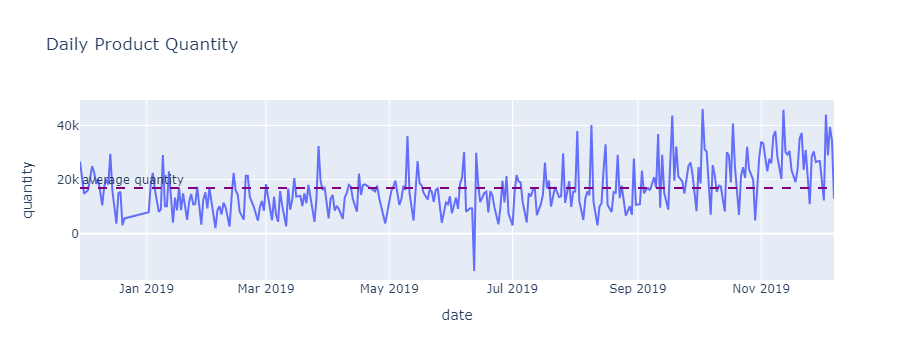

In [40]:
fig = px.line(daily,x="date", y="quantity",title='Daily Product Quantity')
#adding reference line with average daily quantity over time
fig.add_hline(y=daily['quantity'].mean(),line_dash="dash", line_color="purple", annotation_text="average quantity",
             annotation_position="top left")
fig.show()

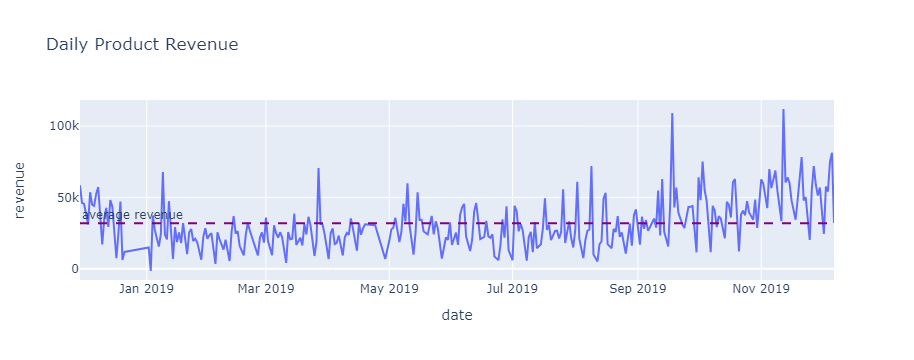

In [41]:
fig = px.line(daily,x="date", y="revenue",title='Daily Product Revenue')
#adding reference line with average daily revenue over time
fig.add_hline(y=daily['revenue'].mean(),line_dash="dash", line_color="purple", annotation_text="average revenue",
             annotation_position="top left")
fig.show()

First of all we notice that although the whole period covers more than a year, there are only 305 rows in `daily` table, so about 70 days are missing in logs - Sundays and holidays.

Both quantity and revenue lines from mostly above average values go down in the middle of december with min values on Jan 3.2019 (Cristmass - New Year period), then with big fluctuations gradually go up and from the end of October 2019 stay above average. There'a a drop in quantity on Jun 12 (big papercraft purchase was returned). The most profitable days are Nov 12 ( revenue 112.1411K) and Sep 18 (109.2862K), which can be related with some marketing events, the least profitable day was Jan 3 (-1566.23).

### Weekly quantity and revenue

Let's consider product quantity and revenue per week.

In [42]:
weekly=data.groupby('week'). agg({'quantity':'sum', 'revenue':'sum'}).reset_index()
weekly.head()

week  quantity    revenue
0 2018-11-26     62460  150115.26
1 2018-12-03    123653  283454.57
2 2018-12-10    111960  216041.64
3 2018-12-17     42965   97112.14
4 2018-12-31     65295   77969.18

Let's plot line graphs for weekly product quantity and weekly revenue.

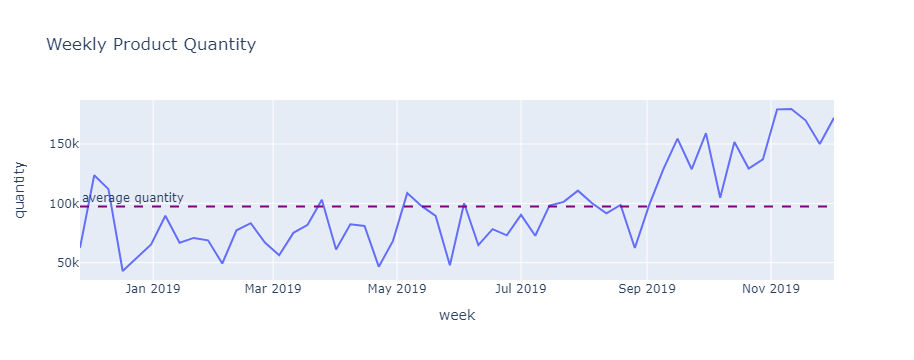

In [43]:
fig = px.line(weekly,x="week", y="quantity",title='Weekly Product Quantity')
#adding reference line with average weekly quantity over time
fig.add_hline(y=weekly['quantity'].mean(),line_dash="dash", line_color="purple", annotation_text="average quantity",
             annotation_position="top left")
fig.show()

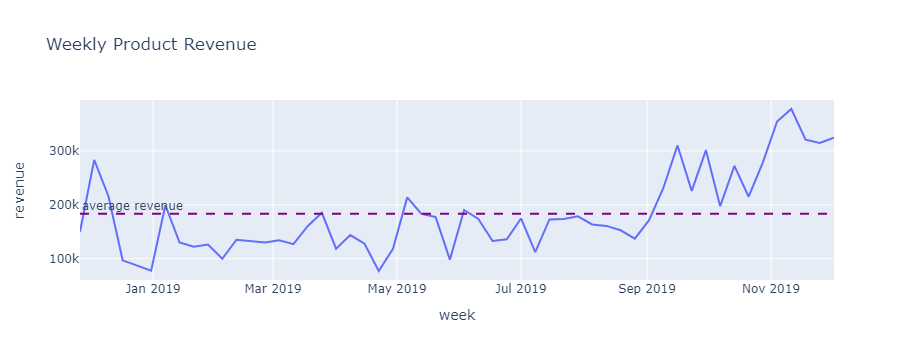

In [44]:
fig = px.line(weekly,x="week", y="revenue",title='Weekly Product Revenue')
#adding reference line with average weekly revenue over time
fig.add_hline(y=weekly['revenue'].mean(),line_dash="dash", line_color="purple", annotation_text="average revenue",
             annotation_position="top left")
fig.show()

These graphs are more readable (fluctuation frequency is smaller), but the general tendency is the same.  The most successful weeks come in autumn, the product quantity and revenue grow until mid-December, stay around the min values at the end of 2018 - begining of 2019,  then keep fluctuating below average till the next autumn.

### Monthly quantity and revenue

Let's do the same for months.

In [45]:
monthly=data.groupby('month'). agg({'quantity':'sum', 'revenue':'sum'}).reset_index()
monthly.head()

month  quantity    revenue
0 2018-11-01     47671  104539.88
1 2018-12-01    293367  642183.73
2 2019-01-01    332933  607854.45
3 2019-02-01    273324  491357.55
4 2019-03-01    347902  662566.86

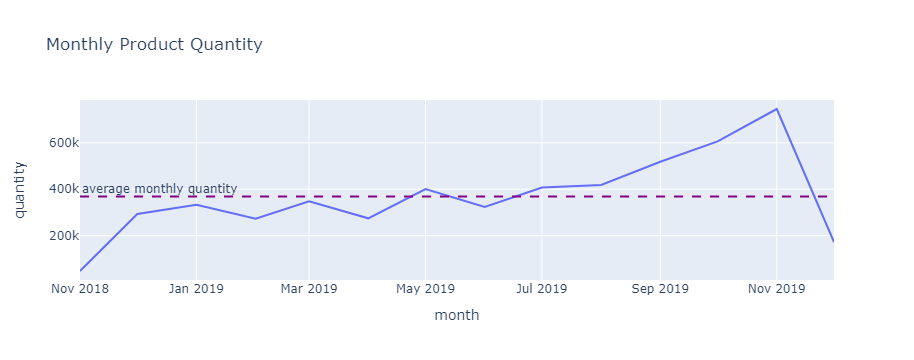

In [46]:
fig = px.line(monthly,x="month", y="quantity",title='Monthly Product Quantity')
#adding reference line with average monthly quantity over time
fig.add_hline(y=monthly['quantity'].mean(),line_dash="dash", line_color="purple", annotation_text="average monthly quantity",
             annotation_position="top left")
fig.show()

The most successful month in terms of quantity is November, the least successful months are February and April. Both edges of the graph represent just some days of the months(Nov 2018, Dec 2019), so we don't take them into account.

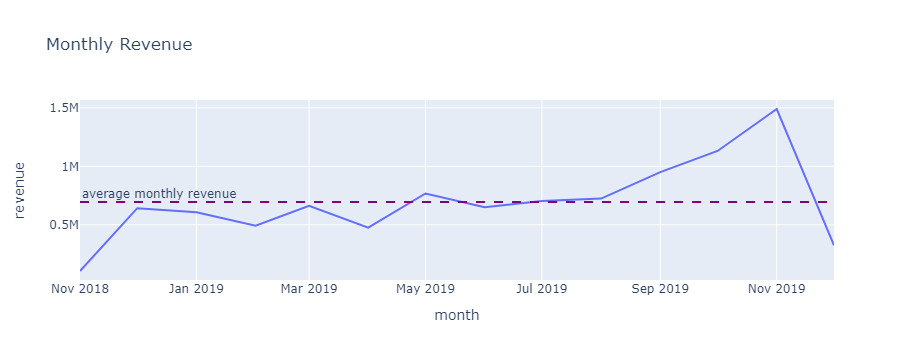

In [47]:
fig = px.line(monthly,x="month", y="revenue",title='Monthly Revenue')
#adding reference line with average monthly revenue over time
fig.add_hline(y=monthly['revenue'].mean(),line_dash="dash", line_color="purple", annotation_text="average monthly revenue",
             annotation_position="top left")
fig.show()

The most profitable months is November. Months from July onwards have revenue above average, while min revenue is in April.

### Day of the week

In [48]:
dowly = data.groupby(['dow']).agg({'quantity':'sum', 'revenue':'sum'}).reset_index()
dowly

dow  quantity      revenue
0    0    462263   798659.461
1    1    813178  1584895.301
2    2    961133  1965703.611
3    3    967222  1730088.430
4    4   1165600  2108701.530
5    5    793106  1537958.621

We see that the store is open 6 days a week from Monday(0) to Saturday(5), but on Sunday it's closed. We can find the most successful day of the week.

Let's plot a barplot for quantity and revenue distribution per dow.

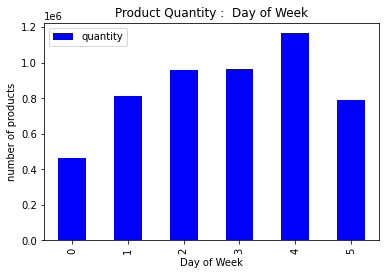

In [49]:
dowly.plot(kind='bar', x='dow', y='quantity', color='blue')
plt.xlabel('Day of Week')
plt.ylabel('number of products')
plt.title('Product Quantity :  Day of Week')
plt.show()

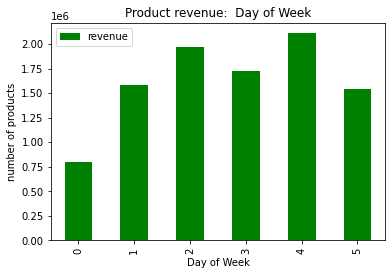

In [50]:
dowly.plot(kind='bar', x='dow', y='revenue', color='green')
plt.xlabel('Day of Week')
plt.ylabel('number of products')
plt.title('Product revenue:  Day of Week')
plt.show()

The most successful day of the week is Friday in terms of both quantity and revenue (no wonder - short working day before the weekend, more time for shopping, more reasons to buy). Wednesday and Thursday do not differ by product quality, but the revenue is greater on Wednesday. On Tuesday and Saturday the revenue is the same(as it was with the quantity).  Monday is the least successful day, it has min quantity and revenue values.

So days of the week can be ordered from the most to the least successful for the shop:
- Friday
- Wednesday
- Thursday
- Tuesday and Saturday
- Monday

## **Conclusion**

The core parameters of our data  which are connected with product were analized in general, per transaction.
`Quantity`   - the mean is 9.55, varies from the negative values (in case of product returns) up to 80995.
`Price` - the mean is 4.61, varies up to 38970. Two negative values in the operations of debt return.
`Revenue` was calculated by multiplying price and quantity. The mean is 17.9 per product per transaction, the maximum is 168469.

**Time dynamics** of quantity and revenue was investigated. `Data` stores information from 2018-11-29  to 2019-12-07, but from more than a year there are only 305 dates - Sundays and holidays are missing in the logs.

**Daily** changes show peaks and drops over the year: Both quantity and revenue lines from mostly above average values go down in the middle of december with min values on Jan 3.2019 (Cristmass - New Year period), then with big fluctuations gradually go up and from the end of October 2019 stay above average. There'a a drop in quantity on Jun 12 (big papercraft purchase was returned). The most profitable days are Nov 12( revenue 112.1411K) and Sep 18(109.2862K), Oct 3(quantity 46.097), the least profitable day was Jan 3(-1566.23

**Weekly**  general tendency is the same. The most successful weeks come in autumn, the product quantity and revenue grow until mid-December, stay around the min values at the end of 2018 - begining of 2019, then keep fluctuating below average till the next autumn.

**monthly** The most successful month in terms of quantity and revenue is November, the least successful months are February and April.

Distribution per **days of the week**  gives us the order of days from the most to the least successful for the shop:
- Friday
- Wednesday
- Thursday
- Tuesday and Saturday
- Monday

# Step 4. Per product analysis.

Let's group values by product and make a **new `product` df**.


In [51]:
product = data.groupby(['stockcode', 'description','unitprice']).agg(
    purchase=('invoiceno', 'count'),
    quantity=('quantity', 'sum'),
    revenue=('revenue', 'sum'),
    customers=('customerid', 'nunique'),
    date_min=('date', 'min'),
    date_max=('date', 'max'),
    dates_unique = ('date', 'nunique')
).reset_index()
product

stockcode                         description  unitprice  purchase  \
0             10002         INFLATABLE POLITICAL GLOBE        0.00         2   
1             10002         INFLATABLE POLITICAL GLOBE        0.85        50   
2             10002         INFLATABLE POLITICAL GLOBE        1.63         7   
3             10002         INFLATABLE POLITICAL GLOBE        1.66        14   
4             10080            GROOVY CACTUS INFLATABLE       0.00         1   
...             ...                                 ...        ...       ...   
17895  gift_0001_40  Dotcomgiftshop Gift Voucher £40.00      33.33         2   
17896  gift_0001_40  Dotcomgiftshop Gift Voucher £40.00      34.04         1   
17897  gift_0001_50  Dotcomgiftshop Gift Voucher £50.00      41.67         3   
17898  gift_0001_50  Dotcomgiftshop Gift Voucher £50.00      42.55         1   
17899             m                              Manual       2.55         1   

       quantity  revenue  customers   date_min   date_max  dates_unique  
0           177     0.00          1 2019-03-28 2019-04-26             2  
1           824   700.40         41 2018-11-29 2019-04-16            38  
2             9    14.67          1 2019-01-17 2019-03-13             6  
3            27    44.82          1 2018-12-01 2019-01-05             9  
4           170     0.00          1 2019-07-24 2019-07-24             1  
...         ...      ...        ...        ...        ...           ...  
17895         2    66.66          1 2019-04-02 2019-07-25             2  
17896         1    34.04          1 2018-12-18 2018-12-18             1  
17897         3   125.01          1 2019-05-04 2019-06-28             3  
17898         1    42.55          1 2018-12-21 2018-12-21             1  
17899         1     2.55          1 2018-12-19 2018-12-19             1  

[17900 rows x 10 columns]

We got 17900 rows of data with a separate row for the same product with different price. For instance, INFLATABLE POLITICAL GLOBE first was sold at  1.66 (14 purchases), then its price changed three times and finally reached 0. The most popular price was 0.85 - sold 50 times, and that was on 29.11.18 - Black Friday, after which the price dot up again. So prices not always go down with time.

Let's find the mean number of price variants for products:

In [52]:
len(product)/product.stockcode.nunique()

4.522486104092977

So, on average there are  4.5 price variants per product (and 4-5 rows for each product in a table).

Let's group data by stockcode, and **in `pr` table each product will take only one row**. We store in `pr` the main product characteristics such as number of price variants, min and max and average price, summed revenue, min and max dates, number of unique dates, number of description's variants).

In [53]:
pr = data.groupby('stockcode'). agg(price_var=('unitprice', 'nunique'),
                                      price_min = ('unitprice', 'min'),
                                      price_max = ('unitprice', 'max'),                                   
                                      price_avg = ('unitprice', 'mean'),
                                   quantity=('quantity', 'sum'),
                                      revenue=('revenue', 'sum'),
                                      date_min=('date', 'min'), 
                                      date_max=('date', 'max'),
                                      dates_unique = ('date', 'nunique'),
                                      description_var = ('description', 'nunique')).reset_index().sort_values(by='price_var', ascending=False)

pr

stockcode  price_var  price_min  price_max   price_avg  quantity  \
4059       DOT        687       0.00    4505.17  290.495859      1707   
4060         M        260       0.00   38970.00  378.870866      2924   
4062      POST        114       0.00    8142.75   36.933495      6353   
4042         D         75       0.01    1867.86   72.484545     -1194   
4063         S         59       2.80     570.00   51.060484       -58   
...        ...        ...        ...        ...         ...       ...   
2823     72232          1       0.19       0.19    0.190000      3317   
3606    85184c          1       5.79       5.79    5.790000         2   
108     17107D          1       2.55       2.55    2.550000       170   
2821    72140F          1       0.00       0.00    0.000000     -5368   
4069         m          1       2.55       2.55    2.550000         1   

        revenue   date_min   date_max  dates_unique  description_var  
4059  206245.48 2018-11-29 2019-12-07           227                1  
4060  -69034.19 2018-11-29 2019-12-07           216                1  
4062   66230.64 2018-11-29 2019-12-07           278                1  
4042   -5696.22 2018-11-29 2019-11-29            50                1  
4063   -3039.65 2018-12-05 2019-11-16            13                1  
...         ...        ...        ...           ...              ...  
2823     630.23 2018-11-30 2019-12-07            57                1  
3606      11.58 2019-08-22 2019-10-24             2                1  
108      433.50 2018-12-01 2019-12-03            41                3  
2821       0.00 2019-03-07 2019-03-07             1                1  
4069       2.55 2018-12-19 2018-12-19             1                1  

[4070 rows x 11 columns]

To add column with descriptions let's take stockcode_description_mapping  we used for filling empty descriptions, so we take the most common description for every stockcode.

In [54]:
stockcode_description_mapping = data.groupby('stockcode')['description'].first().to_dict()
pr['description'] = pr['stockcode'].map(stockcode_description_mapping)
pr

stockcode  price_var  price_min  price_max   price_avg  quantity  \
4059       DOT        687       0.00    4505.17  290.495859      1707   
4060         M        260       0.00   38970.00  378.870866      2924   
4062      POST        114       0.00    8142.75   36.933495      6353   
4042         D         75       0.01    1867.86   72.484545     -1194   
4063         S         59       2.80     570.00   51.060484       -58   
...        ...        ...        ...        ...         ...       ...   
2823     72232          1       0.19       0.19    0.190000      3317   
3606    85184c          1       5.79       5.79    5.790000         2   
108     17107D          1       2.55       2.55    2.550000       170   
2821    72140F          1       0.00       0.00    0.000000     -5368   
4069         m          1       2.55       2.55    2.550000         1   

        revenue   date_min   date_max  dates_unique  description_var  \
4059  206245.48 2018-11-29 2019-12-07           227                1   
4060  -69034.19 2018-11-29 2019-12-07           216                1   
4062   66230.64 2018-11-29 2019-12-07           278                1   
4042   -5696.22 2018-11-29 2019-11-29            50                1   
4063   -3039.65 2018-12-05 2019-11-16            13                1   
...         ...        ...        ...           ...              ...   
2823     630.23 2018-11-30 2019-12-07            57                1   
3606      11.58 2019-08-22 2019-10-24             2                1   
108      433.50 2018-12-01 2019-12-03            41                3   
2821       0.00 2019-03-07 2019-03-07             1                1   
4069       2.55 2018-12-19 2018-12-19             1                1   

                              description  
4059                       DOTCOM POSTAGE  
4060                               Manual  
4062                              POSTAGE  
4042                             Discount  
4063                              SAMPLES  
...                                   ...  
2823              FENG SHUI PILLAR CANDLE  
3606  SET 4 VALENTINE DECOUPAGE HEART BOX  
108   FLOWER FAIRY,5 SUMMER B'DRAW LINERS  
2821                           throw away  
4069                               Manual  

[4070 rows x 12 columns]

Now we have 4070 unique products. 

In [55]:
pr.price_var.describe()

count    4070.000000
mean        4.251597
std        11.847627
min         1.000000
25%         2.000000
50%         4.000000
75%         5.000000
max       687.000000
Name: price_var, dtype: float64

687 price variants! What is it?

In [56]:
pr[ pr['price_var'] == 687]

stockcode  price_var  price_min  price_max   price_avg  quantity  \
4059       DOT        687        0.0    4505.17  290.495859      1707   

        revenue   date_min   date_max  dates_unique  description_var  \
4059  206245.48 2018-11-29 2019-12-07           227                1   

         description  
4059  DOTCOM POSTAGE

In [57]:
product[ product['stockcode'] == 'DOT']

stockcode     description  unitprice  purchase  quantity  revenue  \
16765       DOT  DOTCOM POSTAGE       0.00         3      1002     0.00   
16766       DOT  DOTCOM POSTAGE       0.35         1         1     0.35   
16767       DOT  DOTCOM POSTAGE       2.29         1         1     2.29   
16768       DOT  DOTCOM POSTAGE       2.51         1         1     2.51   
16769       DOT  DOTCOM POSTAGE       3.29         5         3     9.87   
...         ...             ...        ...       ...       ...      ...   
17447       DOT  DOTCOM POSTAGE    2028.25         1         1  2028.25   
17448       DOT  DOTCOM POSTAGE    2114.00         1         1  2114.00   
17449       DOT  DOTCOM POSTAGE    2196.67         1         1  2196.67   
17450       DOT  DOTCOM POSTAGE    2275.54         1         1  2275.54   
17451       DOT  DOTCOM POSTAGE    4505.17         1         1  4505.17   

       customers   date_min   date_max  dates_unique  
16765          1 2019-03-26 2019-11-30             3  
16766          1 2019-07-18 2019-07-18             1  
16767          1 2019-04-16 2019-04-16             1  
16768          1 2019-01-03 2019-01-03             1  
16769          1 2019-01-26 2019-11-23             5  
...          ...        ...        ...           ...  
17447          1 2019-11-23 2019-11-23             1  
17448          1 2019-12-03 2019-12-03             1  
17449          1 2019-12-03 2019-12-03             1  
17450          1 2019-11-21 2019-11-21             1  
17451          1 2019-08-09 2019-08-09             1  

[687 rows x 10 columns]

Yes, 687 rows for DOTCOM POSTAGE, each with a different price, which varies from 0 to 4505.17. "DOTCOM POSTAGE" typically refers to the postage or shipping fees associated with online orders from a website or online store, it's a charge that customers might incur when purchasing items online. So, DOTCOM POSTAGE is not really a product, so let's exclude it from pr dataframe. We'll also drop rows with other special stockcodes:

In [58]:
values_to_drop = ['DOT', 'POST', 'M', 'D', 'S', 'B','AMAZONFEE', 'BANK CHARGES', 'CRUC', 'CRUK', 'm']
pr = pr[~pr['stockcode'].isin(values_to_drop)]
pr.describe()

price_var    price_min    price_max    price_avg      quantity  \
count  4060.000000  4060.000000  4060.000000  4060.000000   4060.000000   
mean      3.949261     1.834828     6.370444     3.673748   1269.168719   
std       2.099376     4.294924    15.055860     6.781025   3048.740156   
min       1.000000     0.000000     0.000000     0.000000 -14468.000000   
25%       2.000000     0.000000     1.950000     1.102455     32.750000   
50%       4.000000     0.720000     3.830000     2.251873    301.000000   
75%       5.000000     2.100000     7.500000     4.232704   1274.250000   
max      16.000000   145.000000   649.500000   156.428571  56427.000000   

             revenue  dates_unique  description_var  
count    4060.000000   4060.000000      4060.000000  
mean     2408.618220     68.867980         1.177833  
std      6163.843451     68.724076         0.574914  
min       -54.000000      1.000000         0.000000  
25%        96.375000     13.000000         1.000000  
50%       614.270000     47.000000         1.000000  
75%      2081.362500    105.000000         1.000000  
max    164459.490000    305.000000         8.000000

We lost 10 rows, and now in `pr` dataframe there are only products in the narrow sence of the word.


## Fixed VS Flexible Prices
We see that product price can change up to 16 times.
Let's find products with the most stable and the least stable price, we'll call them **fixed and flexible** prices and store in tables `fixed` and `flexible`.

In [59]:
fixed=pr. query('price_var == 1')
fixed

stockcode  price_var  price_min  price_max  price_avg  quantity  revenue  \
3936    90178B          1      11.95      11.95      11.95         1    11.95   
4046  DCGS0057          1       0.00       0.00       0.00        -6     0.00   
3812     90098          1       2.55       2.55       2.55        23    58.65   
49      16156L          1       0.42       0.42       0.42       475   199.50   
937      21923          1       0.00       0.00       0.00        -5     0.00   
...        ...        ...        ...        ...        ...       ...      ...   
112     17164B          1       0.42       0.42       0.42        27    11.34   
2823     72232          1       0.19       0.19       0.19      3317   630.23   
3606    85184c          1       5.79       5.79       5.79         2    11.58   
108     17107D          1       2.55       2.55       2.55       170   433.50   
2821    72140F          1       0.00       0.00       0.00     -5368     0.00   

       date_min   date_max  dates_unique  description_var  \
3936 2018-12-15 2018-12-15             1                1   
4046 2019-01-26 2019-01-26             1                0   
3812 2019-02-01 2019-11-23            11                1   
49   2019-01-05 2019-11-30            17                2   
937  2019-04-26 2019-04-26             1                0   
...         ...        ...           ...              ...   
112  2018-11-29 2019-01-24             8                1   
2823 2018-11-30 2019-12-07            57                1   
3606 2019-08-22 2019-10-24             2                1   
108  2018-12-01 2019-12-03            41                3   
2821 2019-03-07 2019-03-07             1                1   

                              description  
3936    PURPLE CHUNKY GLASS+BEAD NECKLACE  
4046                                 None  
3812     NECKLACE+BRACELET PINK BUTTERFLY  
49                         WRAP, CAROUSEL  
937                                  None  
...                                   ...  
112     ASS COL SMALL SAND GECKO P'WEIGHT  
2823              FENG SHUI PILLAR CANDLE  
3606  SET 4 VALENTINE DECOUPAGE HEART BOX  
108   FLOWER FAIRY,5 SUMMER B'DRAW LINERS  
2821                           throw away  

[466 rows x 12 columns]

In [60]:
fixed.describe()

price_var   price_min   price_max   price_avg     quantity  \
count      466.0  466.000000  466.000000  466.000000   466.000000   
mean         1.0    3.228026    3.228026    3.228026    21.645923   
std          0.0    6.623586    6.623586    6.623586   455.219462   
min          1.0    0.000000    0.000000    0.000000 -5368.000000   
25%          1.0    0.000000    0.000000    0.000000    -1.000000   
50%          1.0    1.650000    1.650000    1.650000     3.000000   
75%          1.0    3.352500    3.352500    3.352500    14.000000   
max          1.0   83.330000   83.330000   83.330000  3317.000000   

           revenue  dates_unique  description_var  
count   466.000000     466.00000       466.000000  
mean     54.326137       5.89485         0.774678  
std     159.381203      15.81233         0.457532  
min     -25.500000       1.00000         0.000000  
25%       0.000000       1.00000         1.000000  
50%       8.725000       1.00000         1.000000  
75%      31.050000       5.00000         1.000000  
max    1764.150000     274.00000         3.000000

These 466 products are sold at just 1 price, which doesn't differ much from  price of other products, as describe() method shows. But the mean quantity of stable products is much smaller than that of the whole sample (21.6 VS 1308.5), so the revenue is smaller too(54.3 VS 2484.5).

Let's find unstable or **flexible** products having >= 8 price variants.

In [61]:
flexible = pr.query('price_var >=8')
flexible

stockcode  price_var  price_min  price_max  price_avg  quantity  \
2733     47566         16       0.00      15.79   5.782134     18010   
2924     79321         16       0.00      17.88   6.710632     10339   
421      21166         15       0.00       4.21   2.379257     10113   
155      20685         14       0.00      16.98   8.922057      4023   
427      21175         14       0.00       4.96   2.761902     10159   
...        ...        ...        ...        ...        ...       ...   
320      20998          8       0.00       5.91   2.624286       174   
177      20719          8       0.00       2.51   1.204153     13180   
880      21846          8       1.63       8.29   4.101635       412   
910      21891          8       0.00       2.51   1.580773      8064   
1799     22895          8       2.55       7.95   3.600523      2052   

       revenue   date_min   date_max  dates_unique  description_var  \
2733  98243.88 2018-12-01 2019-12-07           296                1   
2924  53746.66 2018-11-29 2019-12-07           250                1   
421   20713.34 2018-11-29 2019-12-07           239                2   
155   27588.32 2018-11-29 2019-12-07           260                1   
427   23254.64 2018-11-29 2019-12-07           279                2   
...        ...        ...        ...           ...              ...   
320     505.20 2018-12-01 2019-10-12            61                1   
177   16657.05 2018-11-29 2019-12-07           276                1   
880    1147.57 2018-11-29 2019-12-06            75                1   
910   10445.53 2018-11-29 2019-12-06           207                1   
1799   6316.60 2018-11-29 2019-12-07           185                1   

                              description  
2733                        PARTY BUNTING  
2924                        CHILLI LIGHTS  
421            COOK WITH WINE METAL SIGN   
155                 DOORMAT RED RETROSPOT  
427           GIN + TONIC DIET METAL SIGN  
...                                   ...  
320                ROSE DU SUD OVEN GLOVE  
177                WOODLAND CHARLOTTE BAG  
880         PINK DIAMANTE PEN IN GIFT BOX  
910      TRADITIONAL WOODEN SKIPPING ROPE  
1799  SET OF 2 TEA TOWELS APPLE AND PEARS  

[208 rows x 12 columns]

These 208 products have 8 or more price variants.

In [62]:
flexible.describe()

price_var   price_min   price_max   price_avg      quantity  \
count  208.000000  208.000000  208.000000  208.000000    208.000000   
mean     9.365385    0.825240   11.562019    3.872927   5324.000000   
std      1.656827    1.289977   44.902320    2.930643   6769.241816   
min      8.000000    0.000000    0.850000    0.405548  -1015.000000   
25%      8.000000    0.000000    4.210000    1.798119   1174.750000   
50%      9.000000    0.000000    6.770000    2.730216   2952.500000   
75%     10.000000    1.250000   11.490000    4.986200   6707.750000   
max     16.000000    4.770000  649.500000   16.871848  47260.000000   

             revenue  dates_unique  description_var  
count     208.000000    208.000000       208.000000  
mean    13491.673269    177.278846         1.365385  
std     18290.213570     75.498531         0.890722  
min       381.090000     28.000000         1.000000  
25%      2423.705000    114.000000         1.000000  
50%      7581.570000    180.000000         1.000000  
75%     20018.615000    239.500000         1.000000  
max    164459.490000    305.000000         8.000000

Flexible products do not differ much from other products by price, but the mean quantity and revenue are much greater (5337.2 VS 1308.5, 13517.2 VS 2484.5).

Let's **check correlation between the parameters** for products.

In [63]:
pr.corr()

price_var  price_min  price_max  price_avg  quantity  \
price_var         1.000000  -0.176111   0.116658   0.011939  0.400116   
price_min        -0.176111   1.000000   0.328880   0.634250 -0.091889   
price_max         0.116658   0.328880   1.000000   0.696862 -0.035282   
price_avg         0.011939   0.634250   0.696862   1.000000 -0.090781   
quantity          0.400116  -0.091889  -0.035282  -0.090781  1.000000   
revenue           0.471391  -0.013233   0.164105   0.063742  0.686102   
dates_unique      0.656492  -0.101320   0.025643  -0.048934  0.624700   
description_var   0.257322  -0.083597   0.095397   0.045769  0.114106   

                  revenue  dates_unique  description_var  
price_var        0.471391      0.656492         0.257322  
price_min       -0.013233     -0.101320        -0.083597  
price_max        0.164105      0.025643         0.095397  
price_avg        0.063742     -0.048934         0.045769  
quantity         0.686102      0.624700         0.114106  
revenue          1.000000      0.607355         0.171819  
dates_unique     0.607355      1.000000         0.150994  
description_var  0.171819      0.150994         1.000000

These figures confirm our observations. There is high positive correlation not only between  `revenue` and `quantity`(0.69) as expected, but also between  `revenue` and `price_var`(0.47),  `quantity` and `price_var`(0.4). Price discounts increase the customers' interest, that's why the quantity of items sold and the revenue grow for flexible products. **The more flexible prices are, the higher the revenue**!  

## High VS Low Prices. Top 10 by Price.

There is only a weak positive correlation between `revenue` and `price_max`(), no correlation with min or average price. Let's have a closer look at product prices.

First we find the most expensive products and plot them.

In [64]:
price_top= pr.sort_values('price_max', ascending=False).head(10)
price_top

stockcode  price_var  price_min  price_max   price_avg  quantity  \
1422     22502          9       0.00     649.50   10.088233      1870   
1569     22656          5       0.00     295.00  138.333333        18   
1568     22655          5       0.00     295.00  147.457447        39   
1733     22826          4      42.50     195.00  115.388889        54   
1734     22827          4       0.00     165.00  145.967742        28   
1735     22828          2     145.00     165.00  156.428571        10   
4040        C2          6       0.00     150.00   49.291667       290   
1730     22823          3       0.00     125.00  102.333333        24   
1740     22833          4       0.00     100.00   40.362857        76   
637      21473          2      19.95      99.96   23.760000        27   

       revenue   date_min   date_max  dates_unique  description_var  \
1422  51023.52 2018-11-29 2019-09-23           166                3   
1569   2885.00 2018-12-11 2019-10-10            23                1   
1568   6394.50 2018-11-30 2019-10-30            37                2   
1733   5692.50 2018-12-08 2019-11-30            39                1   
1734   5000.00 2018-11-29 2019-11-15            27                1   
1735   1530.00 2018-12-06 2019-11-14             7                1   
4040   6986.00 2018-11-29 2019-12-03           106                1   
1730   2745.00 2018-12-19 2019-11-13            13                2   
1740   2603.53 2018-12-03 2019-02-02             7                1   
637     618.66 2018-12-11 2019-11-18            20                1   

                             description  
1422          PICNIC BASKET WICKER SMALL  
1569        VINTAGE BLUE KITCHEN CABINET  
1568         VINTAGE RED KITCHEN CABINET  
1733       LOVE SEAT ANTIQUE WHITE METAL  
1734  RUSTIC  SEVENTEEN DRAWER SIDEBOARD  
1735        REGENCY MIRROR WITH SHUTTERS  
4040                            CARRIAGE  
1730       CHEST NATURAL WOOD 20 DRAWERS  
1740         HALL CABINET WITH 3 DRAWERS  
637    SWEETHEART CREAM STEEL TABLE RECT

In [65]:
price_top [['description', 'price_max']]

description  price_max
1422          PICNIC BASKET WICKER SMALL     649.50
1569        VINTAGE BLUE KITCHEN CABINET     295.00
1568         VINTAGE RED KITCHEN CABINET     295.00
1733       LOVE SEAT ANTIQUE WHITE METAL     195.00
1734  RUSTIC  SEVENTEEN DRAWER SIDEBOARD     165.00
1735        REGENCY MIRROR WITH SHUTTERS     165.00
4040                            CARRIAGE     150.00
1730       CHEST NATURAL WOOD 20 DRAWERS     125.00
1740         HALL CABINET WITH 3 DRAWERS     100.00
637    SWEETHEART CREAM STEEL TABLE RECT      99.96

In [66]:
price_top. price_max.unique()

array([649.5 , 295.  , 195.  , 165.  , 150.  , 125.  , 100.  ,  99.96])

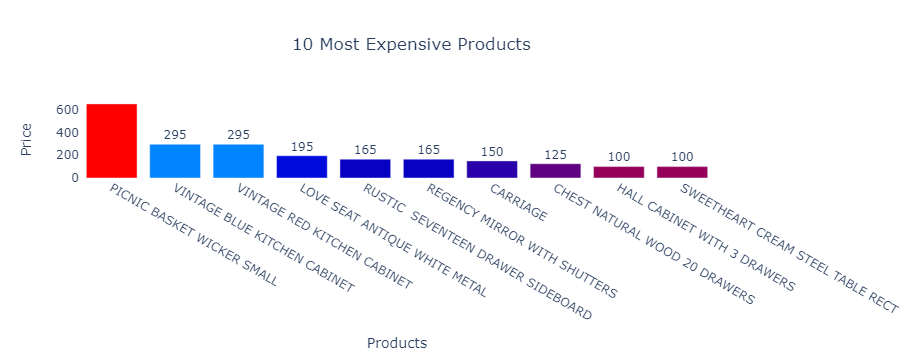

In [67]:
fig = go.Figure(data=[
    go.Bar(name='10 Most Expensive Products', 
           x=price_top['description'], 
           y=price_top['price_max'],
           marker_opacity=1,
           marker={'color': price_top['price_max'],
                   'colorscale': 'Rainbow'})
    ])

fig.update_traces(texttemplate='%{y:.3s}', textposition='outside')
fig.update_layout(barmode='group', showlegend=False)

fig.update_layout(title='10 Most Expensive Products',
                  title_x=0.45,
                  xaxis_title="Products",
                  yaxis_title="Price",
                  plot_bgcolor='white')
fig.show()

The leader by price is PICNIC BASKET WICKER SMALL which costed 649.5. The most expensive products cost  about 100 dollars and more, they mostly belong to household or furniture goods.   Notice that their prices change 2-10 times, and in 7 of 10 products  drop to 0 - the most expensive products become the cheepest!  It may happen in cases of product damage, so to ensure product safety at storage and transportation is the question of maximum importance.

Now let's choose **the cheepest products** regarding maximum price.

In [68]:
price_desc = pr.sort_values('price_max').reset_index()
price_desc.head(25)

index stockcode  price_var  price_min  price_max  price_avg  quantity  \
0    2821    72140F          1        0.0        0.0        0.0     -5368   
1     401     21134          1        0.0        0.0        0.0         1   
2    3281    84857A          1        0.0        0.0        0.0        -5   
3    3288    84864A          1        0.0        0.0        0.0        -2   
4    3312    84899F          1        0.0        0.0        0.0        -5   
5    3144    84611B          1        0.0        0.0        0.0      -143   
6    3145    84612B          1        0.0        0.0        0.0      -162   
7    3173     84664          1        0.0        0.0        0.0        -1   
8    3176     84670          1        0.0        0.0        0.0        23   
9    3204     84726          1        0.0        0.0        0.0       -14   
10   2569    35824B          1        0.0        0.0        0.0        -8   
11    530     21330          1        0.0        0.0        0.0        -4   
12    236     20825          1        0.0        0.0        0.0        -5   
13   3014    84247C          1        0.0        0.0        0.0         1   
14   3023    84251F          1        0.0        0.0        0.0        -2   
15   3468     85044          1        0.0        0.0        0.0         1   
16   3524     85110          1        0.0        0.0        0.0        -1   
17   2958    82545A          1        0.0        0.0        0.0        -4   
18    609     21432          1        0.0        0.0        0.0        -2   
19    608     21431          1        0.0        0.0        0.0       -21   
20   3296    84875A          1        0.0        0.0        0.0       -17   
21   2981     84007          1        0.0        0.0        0.0        -3   
22   3233    84797B          1        0.0        0.0        0.0        -2   
23   3221     84761          1        0.0        0.0        0.0       -11   
24   2732    47563B          1        0.0        0.0        0.0       -10   

    revenue   date_min   date_max  dates_unique  description_var  description  
0       0.0 2019-03-07 2019-03-07             1                1   throw away  
1       0.0 2018-11-29 2018-11-29             1                0         None  
2       0.0 2019-05-01 2019-05-01             1                0         None  
3       0.0 2019-04-06 2019-04-06             1                0         None  
4       0.0 2019-04-06 2019-04-06             1                0         None  
5       0.0 2019-02-02 2019-02-02             1                1  thrown away  
6       0.0 2019-02-02 2019-02-02             1                1  thrown away  
7       0.0 2019-01-26 2019-01-26             1                0         None  
8       0.0 2018-11-29 2018-11-29             1                0         None  
9       0.0 2019-04-02 2019-04-02             1                0         None  
10      0.0 2019-04-02 2019-04-02             1                0         None  
11      0.0 2019-04-26 2019-04-26             1                0         None  
12      0.0 2019-04-26 2019-04-26             1                0         None  
13      0.0 2018-12-07 2018-12-07             1                0         None  
14      0.0 2019-04-04 2019-04-04             1                0         None  
15      0.0 2018-11-29 2018-11-29             1                0         None  
16      0.0 2019-01-26 2019-01-26             1                0         None  
17      0.0 2019-04-04 2019-04-04             1                0         None  
18      0.0 2019-07-25 2019-07-25             1                0         None  
19      0.0 2018-12-08 2018-12-08             1                0         None  
20      0.0 2019-04-02 2019-04-02             1                0         None  
21      0.0 2019-04-04 2019-04-04             1                0         None  
22      0.0 2019-07-18 2019-07-18             1                0         None  
23      0.0 2019-07-25 2019-07-25             1                0         None  
2

Here up to the 20th position  we find  mostly products that were destroyed at the very beginning, returned, brought 0 revenue. Let's look at products with non-zero initial price and choose 10 cheepest products.

In [69]:
price_desc_flt=price_desc[price_desc['price_max'] != 0]
price_desc_flt.head(10)

index stockcode  price_var  price_min  price_max  price_avg  quantity  \
132   4061      PADS          2       0.00      0.001   0.000750         4   
133     51    16161G          1       0.10      0.100   0.100000       700   
134     40     16043          2       0.00      0.120   0.080000        53   
135     32     16010          2       0.00      0.120   0.090000        23   
136     41     16045          3       0.00      0.120   0.042254      4333   
137     39     16033          2       0.00      0.120   0.096000       960   
138   2518    35271S          2       0.00      0.190   0.126667         6   
139   2898    79063C          3       0.00      0.190   0.176667       555   
140   3006    84206B          1       0.19      0.190   0.190000         5   
141   2943    81952V          1       0.19      0.190   0.190000       365   

     revenue   date_min   date_max  dates_unique  description_var  \
132    0.003 2019-04-13 2019-09-23             3                1   
133   70.000 2019-03-13 2019-11-22            21                1   
134   11.760 2019-06-05 2019-06-08             3                1   
135    3.600 2018-12-03 2019-03-30             4                1   
136  380.000 2018-12-20 2019-12-03            58                2   
137  100.800 2018-12-10 2019-02-15             4                1   
138    3.610 2018-11-29 2019-01-08             3                1   
139   43.650 2019-02-01 2019-12-06            15                1   
140    0.950 2019-11-18 2019-11-18             1                1   
141   69.350 2019-07-02 2019-11-25            24                1   

                            description  
132          PADS TO MATCH ALL CUSHIONS  
133                   WRAP BAD HAIR DAY  
134           POP ART PUSH DOWN RUBBER   
135  FOLDING CAMPING SCISSOR W/KNIF & S  
136          POPART WOODEN PENCILS ASST  
137               MINI HIGHLIGHTER PENS  
138                GOLD PRINT PAPER BAG  
139   RETRO PILL BOX KEY CHAIN,THE KING  
140      CAT WITH SUNGLASSES BLANK CARD  
141      ROUND PURPLE CLOCK WITH SUCKER

These top 10 cheepest products cost 0.001 - 0.19$, but if they are sold in big quantity, the revenue can be hundreds of dollars. PADS TO MATCH ALL CUSHIONS has min price (0.001) and min revenue(0.003) - do we really need to sell them? But POPART WOODEN PENCILS ASST is also very cheap(0.12), but brings revenue 380, it's really worth selling. This question we'll consider later in more detail.

## Large VS small quantity. Top 10 by popularity.
Let's sort products by quantity and find the bestselling and worstselling products. The first 10 rows will get to **Top 10 Most Popular Products**.


In [70]:
quantity_desc = pr.sort_values('quantity', ascending=False)
most_popular = quantity_desc.head(10)
most_popular

stockcode  price_var  price_min  price_max  price_avg  quantity  \
1147     22197          6       0.72       2.46   1.035634     56427   
2997     84077          7       0.11       0.63   0.319963     53751   
3515    85099B         13       0.00       4.95   2.470965     47260   
3536    85123A          8       0.00       5.91   3.104037     38811   
3305     84879          6       0.00       3.19   1.721155     36122   
454      21212          8       0.40       5.00   0.758698     36016   
1982     23084          7       0.00       4.96   2.344752     30597   
1412     22492          5       0.55       1.95   0.781564     26437   
1530     22616         13       0.00       1.00   0.446996     26299   
966      21977          7       0.40       2.13   0.743375     24719   

       revenue   date_min   date_max  dates_unique  description_var  \
1147  50967.92 2018-11-29 2019-12-07           294                2   
2997  13560.09 2018-11-30 2019-12-07           235                1   
3515  92175.79 2018-11-29 2019-12-07           302                1   
3536  97838.45 2018-11-29 2019-12-07           305                4   
3305  58792.42 2018-11-29 2019-12-07           300                2   
454   21047.07 2018-11-29 2019-12-07           299                1   
1982  66661.63 2019-05-08 2019-12-07           142                7   
1412  16810.42 2018-11-29 2019-12-06           210                1   
1530   7967.82 2018-11-29 2019-12-07           239                1   
966   12170.77 2018-11-29 2019-12-07           277                1   

                             description  
1147                SMALL POPCORN HOLDER  
2997   WORLD WAR 2 GLIDERS ASSTD DESIGNS  
3515             JUMBO BAG RED RETROSPOT  
3536  WHITE HANGING HEART T-LIGHT HOLDER  
3305       ASSORTED COLOUR BIRD ORNAMENT  
454      PACK OF 72 RETROSPOT CAKE CASES  
1982                  RABBIT NIGHT LIGHT  
1412             MINI PAINT SET VINTAGE   
1530          PACK OF 12 LONDON TISSUES   
966   PACK OF 60 PINK PAISLEY CAKE CASES

The top ten popular products were sold in quantity of about 25 000 items and more. The leader is POPCORN HOLDER with quantity 56450 items (price_max 2.46, brought 50987 revenue).  The most profitable of the bestselling products is WHITE HANGING HEART T-LIGHT HOLDER - 38830 items sold at  price_max 5.91 and total revenue 97894.5$.

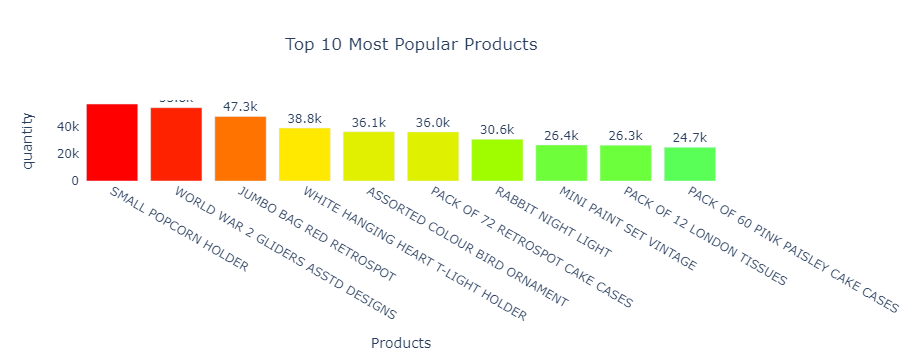

In [71]:
fig = go.Figure(data=[
    go.Bar(name='10 Most Expensive Products', 
           x=most_popular['description'].astype(str), 
           y=most_popular['quantity'],
           marker_opacity=1,
           marker={'color': quantity_desc['quantity'],
                   'colorscale': 'Rainbow'})
    ])

fig.update_traces(texttemplate='%{y:.3s}', textposition='outside')
fig.update_layout(barmode='group', showlegend=False)

fig.update_layout(title='Top 10 Most Popular Products',
                  title_x=0.45,
                  xaxis_title="Products",
                  yaxis_title="quantity",
                  plot_bgcolor='white')
fig.show()

If we look at the df's tail, we get the worstselling products. But at the bottom there are negative values for returns (we'll look at them later), and the min positive quantity is 1. There can be lots of products with only 1 item sold, all candidates for bottom 10. Let's find **products that were sold only once (quantity == 1) and sort values by date**, so that products sold long ago are at the top. 

In [72]:
sold_once=quantity_desc[quantity_desc['quantity' ] == 1][['stockcode','description','revenue', 'date_max']]. sort_values(by = 'date_max').reset_index()
sold_once

index stockcode                         description  revenue   date_max
0    3468     85044                                None     0.00 2018-11-29
1    3638    85226A                                None     0.00 2018-11-29
2     290     20950                                None     0.00 2018-11-29
3     401     21134                                None     0.00 2018-11-29
4    3458    85036b  CHOCOLATE 1 WICK MORRIS BOX CANDLE     8.47 2018-12-01
..    ...       ...                                 ...      ...        ...
60   3103     84550      CROCHET LILAC/RED BEAR KEYRING     1.65 2019-11-23
61   2459     23609      SET 10 CARDS SNOWY ROBIN 17099     2.91 2019-11-26
62   3600    85179a             GREEN BITTY LIGHT CHAIN     2.46 2019-11-27
63   2478     23630  SET 10 CARDS HANGING BAUBLES 17080     2.49 2019-11-28
64   2753    47591b            SCOTTIES CHILDRENS APRON     4.13 2019-12-06

[65 rows x 5 columns]

There are 65 products sold once, but some of them could appear recently in the store and be bought just before the end of the observation period (Nov 29 2018 - Dec 7 2019), like SCOTTIES CHILDRENS APRON bought on Dec 06 12 2019. Let's take to **Bottom 10  by Popularity  Products**  sold_once products with the earliest date of sale.

In [73]:
sold_once.head(10)

index stockcode                         description  revenue   date_max
0   3468     85044                                None     0.00 2018-11-29
1   3638    85226A                                None     0.00 2018-11-29
2    290     20950                                None     0.00 2018-11-29
3    401     21134                                None     0.00 2018-11-29
4   3458    85036b  CHOCOLATE 1 WICK MORRIS BOX CANDLE     8.47 2018-12-01
5   2863    72803b  OCEAN SCENT CANDLE JEWELLED DRAWER     8.47 2018-12-01
6   2526    35597B            BLACKCHRISTMAS TREE 30CM     1.25 2018-12-04
7   3453    85035c       ROSE 3 WICK MORRIS BOX CANDLE     8.47 2018-12-05
8    254     20849                                None     0.00 2018-12-06
9   2862    72803B                                None     0.00 2018-12-06

These productes were sold  about a year ago, they are the least popular products. Is there any sense to keep them selling?

## Returned products. Top 10 by returns.

Min values for quantity are stored in `quantity_desc.tail()`.

In [74]:
quantity_desc.tail(10)

stockcode  price_var  price_min  price_max  price_avg  quantity  revenue  \
1532     22618          4        0.0      19.96  10.173437     -1632   497.35   
2925    79323B          2        0.0       6.75   5.062500     -1671     0.00   
2929    79323P          2        0.0       6.75   5.062500     -2007   -27.00   
1959     23059          1        0.0       0.00   0.000000     -2376     0.00   
2833     72732          1        0.0       0.00   0.000000     -2472     0.00   
2928   79323LP          1        0.0       0.00   0.000000     -2618     0.00   
2931    79323W          2        0.0       6.75   3.375000     -4838   -54.00   
2821    72140F          1        0.0       0.00   0.000000     -5368     0.00   
1905     23003          3        0.0       0.42   0.411273     -8516   226.20   
1907     23005          5        0.0       1.00   0.517085    -14468  2126.13   

       date_min   date_max  dates_unique  description_var  \
1532 2018-11-29 2019-06-26            24                2   
2925 2019-01-04 2019-10-29             3                2   
2929 2019-01-08 2019-10-29             4                2   
1959 2019-05-09 2019-05-09             1                1   
2833 2019-03-21 2019-03-21             1                1   
2928 2019-10-29 2019-10-29             1                1   
2931 2019-01-17 2019-10-29             2                2   
2821 2019-03-07 2019-03-07             1                1   
1905 2019-02-14 2019-06-12            44                2   
1907 2019-02-15 2019-12-07           124                2   

                           description  
1532             COOKING SET RETROSPOT  
2925               BLACK CHERRY LIGHTS  
2929                PINK CHERRY LIGHTS  
1959                 Thrown away-rusty  
2833            thrown away-can't sell  
2928            Unsaleable, destroyed.  
2931               WHITE CHERRY LIGHTS  
2821                        throw away  
1905  TRAVEL CARD WALLET VINTAGE ROSE   
1907  TRAVEL CARD WALLET I LOVE LONDON

TRAVEL CARD WALLET I LOVE LONDON is the worst, 14418 units were returned! But thet row looks weird - quantity is negative, but revenue is positive. Let's dive deeper and look at all products with this stockcode - in `product` df.

In [75]:
product[product['stockcode'] == '23005']

stockcode                       description  unitprice  purchase  \
9339     23005  TRAVEL CARD WALLET I LOVE LONDON       0.36         2   
9340     23005  TRAVEL CARD WALLET I LOVE LONDON       0.42       183   
9341     23005  TRAVEL CARD WALLET I LOVE LONDON       0.83        58   
9342     23005  TRAVEL CARD WALLET I LOVE LONDON       1.00         2   
9343     23005      printing smudges/thrown away       0.00         2   

      quantity  revenue  customers   date_min   date_max  dates_unique  
9339       960   345.60          1 2019-07-22 2019-11-01             2  
9340      3394  1425.48        105 2019-02-15 2019-12-06           108  
9341       135   112.05          1 2019-06-18 2019-12-07            48  
9342       243   243.00          1 2019-11-05 2019-11-12             2  
9343    -19200     0.00          1 2019-06-12 2019-06-12             1

Now this product history is clear - it was successfully sold at 4 different prices from Feb 15 to Dec 7, but in June a large batch of wallets (damaged) was discounted to 0 and returned. In total we have negative quantity of product sold, but significant positive revenue.

We gather all products returned in `returns` df

In [76]:
returnes = product[product['quantity'] < 0].groupby(['stockcode', 'description']). agg(price_var=('unitprice', 'count'),
                                      price_min = ('unitprice', 'min'),
                                      price_max = ('unitprice', 'max'),                                   
                                      price_avg = ('unitprice', 'mean'),
                                   quantity=('quantity', 'sum'),
                                      revenue=('revenue', 'sum'),
                                      date_min=('date_min', 'min'), 
                                      date_max=('date_max', 'max')).sort_values(by = 'quantity')
                                     
returnes

price_var  price_min  \
stockcode description                                                 
23005     printing smudges/thrown away                 1       0.00   
84347     ROTATING SILVER ANGELS T-LIGHT HLDR          1       0.03   
23003     Printing smudges/thrown away                 1       0.00   
72140F    throw away                                   1       0.00   
79323W    Unsaleable, destroyed.                       1       0.00   
...                                                  ...        ...   
22655     VINTAGE RED KITCHEN CABINET                  1     265.50   
85032D    damaged                                      1       0.00   
85031C    CURIOUS IMAGES SCRAP BOOK SET                1       0.00   
85119     WATERING CAN SINGLE HOOK PISTACHIO           1       0.00   
84927D    LA PALMIERA TILE HOOK                        1       0.00   

                                               price_max  price_avg  quantity  \
stockcode description                                                           
23005     printing smudges/thrown away              0.00       0.00    -19200   
84347     ROTATING SILVER ANGELS T-LIGHT HLDR       0.03       0.03     -9360   
23003     Printing smudges/thrown away              0.00       0.00     -9058   
72140F    throw away                                0.00       0.00     -5368   
79323W    Unsaleable, destroyed.                    0.00       0.00     -4830   
...                                                  ...        ...       ...   
22655     VINTAGE RED KITCHEN CABINET             265.50     265.50        -1   
85032D    damaged                                   0.00       0.00        -1   
85031C    CURIOUS IMAGES SCRAP BOOK SET             0.00       0.00        -1   
85119     WATERING CAN SINGLE HOOK PISTACHIO        0.00       0.00        -1   
84927D    LA PALMIERA TILE HOOK                     0.00       0.00        -1   

                                               revenue   date_min   date_max  
stockcode description                                                         
23005     printing smudges/thrown away             0.0 2019-06-12 2019-06-12  
84347     ROTATING SILVER ANGELS T-LIGHT HLDR   -280.8 2018-11-30 2018-11-30  
23003     Printing smudges/thrown away             0.0 2019-06-12 2019-06-12  
72140F    throw away                               0.0 2019-03-07 2019-03-07  
79323W    Unsaleable, destroyed.                   0.0 2019-10-29 2019-10-29  
...                                                ...        ...        ...  
22655     VINTAGE RED KITCHEN CABINET           -265.5 2019-01-08 2019-01-08  
85032D    damaged                                  0.0 2019-10-25 2019-10-25  
85031C    CURIOUS IMAGES SCRAP BOOK SET            0.0 2019-01-26 2019-01-26  
85119     WATERING CAN SINGLE HOOK PISTACHIO       0.0 2019-01-26 2019-01-26  
84927D    LA PALMIERA TILE HOOK                    0.0 2019-07-26 2019-07-26  

[1119 rows x 8 columns]

In [77]:
returnes.describe()

price_var    price_min     price_max    price_avg      quantity  \
count  1119.000000  1119.000000   1119.000000  1119.000000   1119.000000   
mean      1.376229     0.646550     56.275845     8.824223   -190.911528   
std       5.437777     8.426877   1282.815977   223.781217    811.065276   
min       1.000000     0.000000      0.000000     0.000000 -19200.000000   
25%       1.000000     0.000000      0.000000     0.000000   -100.000000   
50%       1.000000     0.000000      0.000000     0.000000    -37.000000   
75%       1.000000     0.000000      0.000000     0.000000    -12.000000   
max     140.000000   265.500000  38970.000000  7433.721724     -1.000000   

             revenue  
count    1119.000000  
mean     -306.871466  
std      7134.493900  
min   -221520.500000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         0.000000

1119 products  got returned, their quantity varies from -1 to  -19200 items, product 23005 TRAVEL CARD WALLET I LOVE LONDON has max number of returnes. Let's find **TOP 10 Returns** products (we don't drop products with codes 'M', S ... in this task).

In [78]:
returnes.head(10)

price_var  price_min  \
stockcode description                                                 
23005     printing smudges/thrown away                 1       0.00   
84347     ROTATING SILVER ANGELS T-LIGHT HLDR          1       0.03   
23003     Printing smudges/thrown away                 1       0.00   
72140F    throw away                                   1       0.00   
79323W    Unsaleable, destroyed.                       1       0.00   
16045     POPART WOODEN PENCILS ASST                   1       0.00   
M         Manual                                     140       0.03   
16259     PIECE OF CAMO STATIONERY SET                 1       0.00   
20713     wrongly marked. 23343 in box                 1       0.00   
84598     check                                        1       0.00   

                                               price_max   price_avg  \
stockcode description                                                  
23005     printing smudges/thrown away              0.00    0.000000   
84347     ROTATING SILVER ANGELS T-LIGHT HLDR       0.03    0.030000   
23003     Printing smudges/thrown away              0.00    0.000000   
72140F    throw away                                0.00    0.000000   
79323W    Unsaleable, destroyed.                    0.00    0.000000   
16045     POPART WOODEN PENCILS ASST                0.00    0.000000   
M         Manual                                38970.00  614.277857   
16259     PIECE OF CAMO STATIONERY SET              0.00    0.000000   
20713     wrongly marked. 23343 in box              0.00    0.000000   
84598     check                                     0.00    0.000000   

                                               quantity   revenue   date_min  \
stockcode description                                                          
23005     printing smudges/thrown away           -19200      0.00 2019-06-12   
84347     ROTATING SILVER ANGELS T-LIGHT HLDR     -9360   -280.80 2018-11-30   
23003     Printing smudges/thrown away            -9058      0.00 2019-06-12   
72140F    throw away                              -5368      0.00 2019-03-07   
79323W    Unsaleable, destroyed.                  -4830      0.00 2019-10-29   
16045     POPART WOODEN PENCILS ASST              -3667      0.00 2019-09-12   
M         Manual                                  -3551 -88119.52 2018-11-29   
16259     PIECE OF CAMO STATIONERY SET            -3167      0.00 2019-08-31   
20713     wrongly marked. 23343 in box            -3100      0.00 2019-07-12   
84598     check                                   -3000      0.00 2019-03-06   

                                                date_max  
stockcode description                                     
23005     printing smudges/thrown away        2019-06-12  
84347     ROTATING SILVER ANGELS T-LIGHT HLDR 2018-11-30  
23003     Printing smudges/thrown away        2019-06-12  
72140F    throw away                          2019-03-07  
79323W    Unsaleable, destroyed.              2019-10-29  
16045     POPART WOODEN PENCILS ASST          2019-09-12  
M         Manual                              2019-12-07  
16259     PIECE OF CAMO STATIONERY SET        2019-08-31  
20713     wrongly marked. 23343 in box        2019-07-12  
84598     check                               2019-03-06

These products need special attention if we want to increase the stores revenue.

## High VS Low Revenue products. Top ten by revenue

We can sort data by revenue and find the most profitable products.

In [79]:
profitable = pr.sort_values(by = 'revenue', ascending = False).head(10)
profitable

stockcode  price_var  price_min  price_max  price_avg  quantity  \
1348     22423         10       0.00      32.04  13.787482     12954   
2733     47566         16       0.00      15.79   5.782134     18010   
3536    85123A          8       0.00       5.91   3.104037     38811   
3515    85099B         13       0.00       4.95   2.470965     47260   
1982     23084          7       0.00       4.96   2.344752     30597   
1043     22086          7       2.55       6.95   3.356533     18876   
3305     84879          6       0.00       3.19   1.721155     36122   
2924     79321         16       0.00      17.88   6.710632     10339   
1422     22502          9       0.00     649.50  10.088233      1870   
1147     22197          6       0.72       2.46   1.035634     56427   

        revenue   date_min   date_max  dates_unique  description_var  \
1348  164459.49 2018-11-29 2019-12-07           301                3   
2733   98243.88 2018-12-01 2019-12-07           296                1   
3536   97838.45 2018-11-29 2019-12-07           305                4   
3515   92175.79 2018-11-29 2019-12-07           302                1   
1982   66661.63 2019-05-08 2019-12-07           142                7   
1043   63715.24 2018-11-29 2019-12-07           161                1   
3305   58792.42 2018-11-29 2019-12-07           300                2   
2924   53746.66 2018-11-29 2019-12-07           250                1   
1422   51023.52 2018-11-29 2019-09-23           166                3   
1147   50967.92 2018-11-29 2019-12-07           294                2   

                             description  
1348            REGENCY CAKESTAND 3 TIER  
2733                       PARTY BUNTING  
3536  WHITE HANGING HEART T-LIGHT HOLDER  
3515             JUMBO BAG RED RETROSPOT  
1982                  RABBIT NIGHT LIGHT  
1043     PAPER CHAIN KIT 50'S CHRISTMAS   
3305       ASSORTED COLOUR BIRD ORNAMENT  
2924                       CHILLI LIGHTS  
1422          PICNIC BASKET WICKER SMALL  
1147                SMALL POPCORN HOLDER

Let's plot top 10 profitable products

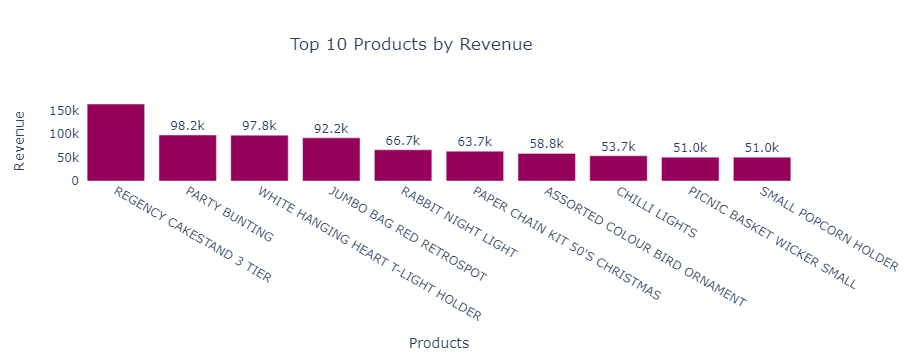

In [80]:
fig = go.Figure(data=[
    go.Bar(name='Top 10 Products by Revenue', 
           x=profitable['description'], 
           y=profitable['revenue'],
           marker_opacity=1,
           marker={'color': price_desc['revenue'],
                   'colorscale': 'Rainbow'})
    ])

fig.update_traces(texttemplate='%{y:.3s}', textposition='outside')
fig.update_layout(barmode='group', showlegend=False)

fig.update_layout(title='Top 10 Products by Revenue',
                  title_x=0.45,
                  xaxis_title="Products",
                  yaxis_title="Revenue",
                  plot_bgcolor='white')
fig.show()

The leader is REGENCY CAKESTAND 3 TIER which brought 164.7622k, the last product in top 10 brought 51.0k of revenue.

Let's consider products with min revenue.

In [81]:
unprofitable = pr[pr['revenue'] < 0].sort_values(by = 'revenue').reset_index()
unprofitable

index stockcode  price_var  price_min  price_max  price_avg  quantity  \
0    2931    79323W          2       0.00       6.75   3.375000     -4838   
1    3493     85063          2      14.95      16.95  15.950000        -3   
2    2519     35400          3       0.00       8.95   7.146875         2   
3     734     21645          2       0.00       1.65   0.825000       -25   
4    2929    79323P          2       0.00       6.75   5.062500     -2007   
5     167     20703          1       4.25       4.25   4.250000        -6   
6    3467     85042          1       4.95       4.95   4.950000        -3   
7    3495     85065          1      12.75      12.75  12.750000        -1   
8    2657     37503          1      10.75      10.75  10.750000        -1   
9    3498     85068          2       0.00       7.95   3.975000        -5   
10   3215    84750A          2       0.00       1.95   1.462500       -13   
11   3268     84839          1       5.55       5.55   5.550000        -1   
12   2923     79320          1       4.95       4.95   4.950000        -1   
13   3514    85098B          2       0.00       3.75   1.875000        -6   
14   2570     35832          1       2.95       2.95   2.950000        -1   
15   3426    85023C          1       2.55       2.55   2.550000        -1   
16    591     21412          2       0.00       0.42   0.210000       -12   
17    293     20957          1       1.45       1.45   1.450000        -1   
18    994     22034          3       0.00       0.83   0.324444      -236   

    revenue   date_min   date_max  dates_unique  description_var  \
0    -54.00 2019-01-17 2019-10-29             2                2   
1    -46.85 2019-01-30 2019-04-02             2                1   
2    -45.70 2018-12-04 2019-11-21            13                1   
3    -39.60 2019-01-04 2019-01-26             2                1   
4    -27.00 2019-01-08 2019-10-29             4                2   
5    -25.50 2018-12-06 2019-05-31             4                1   
6    -14.85 2019-01-03 2019-01-04             2                1   
7    -12.75 2019-02-20 2019-02-20             1                1   
8    -10.75 2018-12-13 2018-12-13             1                1   
9     -7.95 2018-12-06 2019-04-24             2                1   
10    -5.85 2019-03-18 2019-05-01             4                1   
11    -5.55 2019-04-09 2019-04-09             1                1   
12    -4.95 2019-01-03 2019-01-03             1                1   
13    -3.75 2019-03-11 2019-05-01             2                1   
14    -2.95 2018-12-12 2018-12-12             1                1   
15    -2.55 2019-01-07 2019-01-07             1                1   
16    -2.52 2019-01-03 2019-05-01             2                1   
17    -1.45 2018-11-29 2018-11-29             1                1   
18    -0.02 2018-12-03 2019-11-23             9                1   

                            description  
0                   WHITE CHERRY LIGHTS  
1        CREAM SWEETHEART MAGAZINE RACK  
2           WOODEN BOX ADVENT CALENDAR   
3       ASSORTED TUTTI FRUTTI ROUND BOX  
4                    PINK CHERRY LIGHTS  
5               BLUE PADDED SOFT MOBILE  
6             ANTIQUE LILY FAIRY LIGHTS  
7                CREAM SWEETHEART TRAYS  
8       TEA TIME CAKE STAND IN GIFT BOX  
9        CREAM SWEETHEART SHELF + HOOKS  
10          PINK SMALL GLASS CAKE STAND  
11               SWEETHEART KEY CABINET  
12                      FLAMINGO LIGHTS  
13           BLUE FLYING SINGING CANARY  
14  WOOLLY HAT SOCK GLOVE ADVENT STRING  
15        PINK LARGE JEWELED PHOTOFRAME  
16             VINTAGE GOLD TINSEL REEL  
17         PORCELAIN HANGING BELL SMALL  
18                 ROBIN CHRISTMAS CARD

These 19 products with negative revenue brought losses from -0.02 to -54.00.

Let's find meaningful description for the product in the 1sr row by its stockcode.

In [82]:
product[product['stockcode'] == '79323W']

stockcode             description  unitprice  purchase  quantity  \
12973    79323W  Unsaleable, destroyed.       0.00         1     -4830   
12974    79323W     WHITE CHERRY LIGHTS       6.75         1        -8   

       revenue  customers   date_min   date_max  dates_unique  
12973      0.0          1 2019-10-29 2019-10-29             1  
12974    -54.0          1 2019-01-17 2019-01-17             1

So **the worst product max losses** is WHITE CHERRY LIGHTS, its revenue is -54.0 - 8 items at price 6.75 were returned on Jan 17 2019, but later, on Oct 29  4830 destroyed items were returned with 0 revenue. 

Let's consider 0 revenue products too.

In [83]:
zero_revenue = pr[pr['revenue'] == 0].reset_index()
zero_revenue

index stockcode  price_var  price_min  price_max  price_avg  quantity  \
0     2925    79323B          2        0.0       6.75   5.062500     -1671   
1      749     21667          2        0.0      14.95   4.983333         1   
2      741     21655          2        0.0       1.69   1.408333        19   
3     4046  DCGS0057          1        0.0       0.00   0.000000        -6   
4      937     21923          1        0.0       0.00   0.000000        -5   
..     ...       ...        ...        ...        ...        ...       ...   
131   3598    85179B          1        0.0       0.00   0.000000        -1   
132   2838     72781          1        0.0       0.00   0.000000       -30   
133   2835     72759          1        0.0       0.00   0.000000      -524   
134   2833     72732          1        0.0       0.00   0.000000     -2472   
135   2821    72140F          1        0.0       0.00   0.000000     -5368   

     revenue   date_min   date_max  dates_unique  description_var  \
0        0.0 2019-01-04 2019-10-29             3                2   
1        0.0 2019-01-08 2019-01-26             4                1   
2        0.0 2019-01-08 2019-02-09             3                1   
3        0.0 2019-01-26 2019-01-26             1                0   
4        0.0 2019-04-26 2019-04-26             1                0   
..       ...        ...        ...           ...              ...   
131      0.0 2019-01-26 2019-01-26             1                0   
132      0.0 2019-03-30 2019-03-30             1                0   
133      0.0 2019-03-21 2019-03-21             1                1   
134      0.0 2019-03-21 2019-03-21             1                1   
135      0.0 2019-03-07 2019-03-07             1                1   

                            description  
0                   BLACK CHERRY LIGHTS  
1            GLASS CAKE COVER AND PLATE  
2    HANGING RIDGE GLASS T-LIGHT HOLDER  
3                                  None  
4                                  None  
..                                  ...  
131                                None  
132                                None  
133             thrown away-can't sell.  
134              thrown away-can't sell  
135                          throw away  

[136 rows x 13 columns]

These 24 products with zero revenue often have similar descriptions: 'thrown away', 'damages', 'Unsaleable', 'destroyed', 'adjustment' and so on, which clearly show the reason for total discount and return, but don't define the product itself (but we can look it up in `product`, as we did earlier). The reason for return is not always clearly marked in description, it can be hidden by the common description which all products with the same stockcode got after grouping. Such damaged returned producte were present in the above table `unprofitable`.

In some cases the  pruduct is defined by the description: GLASS CAKE COVER AND PLATE,  TRAVEL CARD WALLET DOTCOMGIFTSHOP, and they are not returned(quantity is positive), but are given for free when nobody buys them (their prise was above zero before). And there are cases when products never had positive price and was not returned(quantity is positive) like TRAVEL CARD WALLET DOTCOMGIFTSHOP - 200 items given free. But maybe such products increase customer's interest and in such way increase revenue.

## Long_time VS One_day/One_month on sale products

Let's calculate the interval between max and min dates of purchase.

In [84]:
pr['time_delta']= (pr['date_max']- pr['date_min']).dt.days
pr['time_delta'].describe()

/tmp/ipykernel_44/1548934288.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



count    4060.000000
mean      268.057635
std       129.076102
min         0.000000
25%       173.000000
50%       349.000000
75%       371.000000
max       373.000000
Name: time_delta, dtype: float64

So, the sales period for products can last from 0 to 373 days(= the whole observation period). The mean sales duration  is 276 days, while the median in greater (353 days - almost a year!).

Let's plot a histogtam for sales duration.  

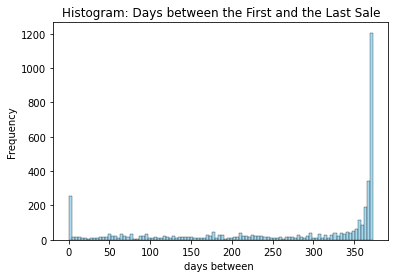

In [85]:
sns.histplot(data=pr, x='time_delta', bins=100, color='skyblue', edgecolor='black')

# Customize the plot
plt.xlabel('days between ')
plt.ylabel('Frequency')
plt.title('Histogram: Days between the First and the Last Sale')

# Show the histogram
plt.show()

The last column is much higher than the others, we see that about  1200 out of 3948 products in data are sold for the whole observation period. And there are 239 products with 0 between the max and min date of sale, so they were bought only once. These products may be new on sales or be sold long time ago.

In [86]:
pr.time_delta.value_counts()

373    563
372    364
0      239
371    170
369    111
      ... 
250      1
27       1
25       1
255      1
288      1
Name: time_delta, Length: 366, dtype: int64

Let's have a look at **products sold for 360 days and more**.

In [87]:
long_sale_products = pr[pr['time_delta'] >= 360]
long_sale_products

stockcode  price_var  price_min  price_max  price_avg  quantity  \
2733     47566         16       0.00      15.79   5.782134     18010   
2924     79321         16       0.00      17.88   6.710632     10339   
421      21166         15       0.00       4.21   2.379257     10113   
155      20685         14       0.00      16.98   8.922057      4023   
427      21175         14       0.00       4.96   2.761902     10159   
...        ...        ...        ...        ...        ...       ...   
2906    79149B          1       0.42       0.42   0.420000        18   
2801    71406C          1       0.42       0.42   0.420000       138   
2837     72780          1       0.85       0.85   0.850000       137   
2823     72232          1       0.19       0.19   0.190000      3317   
108     17107D          1       2.55       2.55   2.550000       170   

       revenue   date_min   date_max  dates_unique  description_var  \
2733  98243.88 2018-12-01 2019-12-07           296                1   
2924  53746.66 2018-11-29 2019-12-07           250                1   
421   20713.34 2018-11-29 2019-12-07           239                2   
155   27588.32 2018-11-29 2019-12-07           260                1   
427   23254.64 2018-11-29 2019-12-07           279                2   
...        ...        ...        ...           ...              ...   
2906      7.56 2018-12-03 2019-12-04             8                1   
2801     57.96 2018-11-29 2019-11-27            21                1   
2837    116.45 2018-12-11 2019-12-06            18                1   
2823    630.23 2018-11-30 2019-12-07            57                1   
108     433.50 2018-12-01 2019-12-03            41                3   

                              description  time_delta  
2733                        PARTY BUNTING         371  
2924                        CHILLI LIGHTS         373  
421            COOK WITH WINE METAL SIGN          373  
155                 DOORMAT RED RETROSPOT         373  
427           GIN + TONIC DIET METAL SIGN         373  
...                                   ...         ...  
2906              SILICON STAR BULB  BLUE         366  
2801                BLACK ORANGE SQUEEZER         363  
2837         BLACK SILOUETTE CANDLE PLATE         360  
2823              FENG SHUI PILLAR CANDLE         372  
108   FLOWER FAIRY,5 SUMMER B'DRAW LINERS         367  

[1799 rows x 13 columns]

In [88]:
len(long_sale_products)/len(pr)

0.44310344827586207

The long_sale products' share is about 44%, there are 1799 unique products. Let's find total revenue of these products.

In [89]:
long_sale_products.revenue.sum()

7055344.560000003

In [90]:
long_sale_products.revenue.sum()/pr.revenue.sum()

0.721479884883813

They give 7069495.77$ revenue, or 72% of the shop's total revenue. 

Let's look at **products sold  in one day** and sort them chronologically.

In [91]:
one_day = pr[pr['time_delta'] < 1].sort_values(by = 'date_max')
one_day

stockcode  price_var  price_min  price_max  price_avg  quantity  revenue  \
3176     84670          1       0.00       0.00       0.00        23     0.00   
3638    85226A          1       0.00       0.00       0.00         1     0.00   
290      20950          1       0.00       0.00       0.00         1     0.00   
293      20957          1       1.45       1.45       1.45        -1    -1.45   
401      21134          1       0.00       0.00       0.00         1     0.00   
...        ...        ...        ...        ...        ...       ...      ...   
2467     23617          1       2.91       2.91       2.91         2     5.82   
3600    85179a          1       2.46       2.46       2.46         1     2.46   
4032    90214U          1       0.29       0.29       0.29        12     3.48   
2753    47591b          1       4.13       4.13       4.13         1     4.13   
2506     23843          1       2.08       2.08       2.08         0     0.00   

       date_min   date_max  dates_unique  description_var  \
3176 2018-11-29 2018-11-29             1                0   
3638 2018-11-29 2018-11-29             1                0   
290  2018-11-29 2018-11-29             1                0   
293  2018-11-29 2018-11-29             1                1   
401  2018-11-29 2018-11-29             1                0   
...         ...        ...           ...              ...   
2467 2019-11-27 2019-11-27             1                1   
3600 2019-11-27 2019-11-27             1                1   
4032 2019-12-03 2019-12-03             1                1   
2753 2019-12-06 2019-12-06             1                1   
2506 2019-12-07 2019-12-07             1                1   

                              description  time_delta  
3176                                 None           0  
3638                                 None           0  
290                                  None           0  
293          PORCELAIN HANGING BELL SMALL           0  
401                                  None           0  
...                                   ...         ...  
2467  SET 10 CARDS SWIRLY XMAS TREE 17104           0  
3600              GREEN BITTY LIGHT CHAIN           0  
4032            LETTER "U" BLING KEY RING           0  
2753             SCOTTIES CHILDRENS APRON           0  
2506          PAPER CRAFT , LITTLE BIRDIE           0  

[239 rows x 13 columns]

`one_day` stores **239 products sold in one day**, here we don't care about quantity (earlier products sold once in quantity of 1 item were considered - `sold_once`). The table's tail shows new products, which may recently appear on sale, their future is difficult to predict. But in `once`  head  there are products sold once almost a year ago and not interesting to customers any more.

Let's consider the revenue.

In [92]:
one_day.sort_values(by = 'revenue', ascending = False).head(30)

stockcode  price_var  price_min  price_max  price_avg  quantity  revenue  \
1214     22275          1       7.65       7.65       7.65        69   527.85   
3355    84963A          1      42.95      42.95      42.95         4   171.80   
3356    84963B          1      49.95      49.95      49.95         3   149.85   
2977     82615          1       2.55       2.55       2.55        36    91.80   
981      22016          1      83.33      83.33      83.33         1    83.33   
516      21310          1      29.95      29.95      29.95         1    29.95   
2698    46776f          1       4.13       4.13       4.13         7    28.91   
3371    84968f          1      25.49      25.49      25.49         1    25.49   
3532    85115B          1       8.29       8.29       8.29         3    24.87   
3725    90035C          1      10.75      10.75      10.75         2    21.50   
82       17001          1       0.29       0.29       0.29        72    20.88   
2695    46776a          1       4.13       4.13       4.13         5    20.65   
3904    90162A          1       2.95       2.95       2.95         6    17.70   
3707    90026A          1       8.50       8.50       8.50         2    17.00   
2991    84031b          1      16.63      16.63      16.63         1    16.63   
2990    84031a          1      16.63      16.63      16.63         1    16.63   
4044  DCGS0004          1      16.63      16.63      16.63         1    16.63   
3457    85036a          1       8.29       8.29       8.29         2    16.58   
3576    85160a          1      16.13      16.13      16.13         1    16.13   
2320     23449          1       1.25       1.25       1.25        12    15.00   
3191    84705C          1       1.25       1.25       1.25        12    15.00   
3783     90069          1       7.50       7.50       7.50         2    15.00   
3792     90078          1       7.50       7.50       7.50         2    15.00   
3076    84509g          1       7.46       7.46       7.46         2    14.92   
3751     90046          1       4.95       4.95       4.95         3    14.85   
3752     90048          1       4.95       4.95       4.95         3    14.85   
2652    37491C          1       1.65       1.65       1.65         8    13.20   
3693     90020          1      12.48      12.48      12.48         1    12.48   
3936    90178B          1      11.95      11.95      11.95         1    11.95   
3694     90021          1      11.95      11.95      11.95         1    11.95   

       date_min   date_max  dates_unique  description_var  \
1214 2018-11-30 2018-11-30             1                1   
3355 2018-12-03 2018-12-03             1                1   
3356 2019-08-02 2019-08-02             1                1   
2977 2018-11-29 2018-11-29             1                1   
981  2019-07-31 2019-07-31             1                1   
516  2019-05-22 2019-05-22             1                1   
2698 2019-10-29 2019-10-29             1                1   
3371 2018-12-19 2018-12-19             1                1   
3532 2019-10-09 2019-10-09             1                1   
3725 2019-05-11 2019-05-11             1                1   
82   2019-02-26 2019-02-26             1                1   
2695 2019-10-29 2019-10-29             1                1   
3904 2019-11-05 2019-11-05             1                1   
3707 2019-06-11 2019-06-11             1                1   
2991 2019-10-29 2019-10-29             1                1   
2990 2019-10-29 2019-10-29             1                1   
4044 2019-04-25 2019-04-25             1                1   
3457 2019-07-10 2019-07-10             1                1   
3576 2018-12-19 2018-12-19             1                1   
2320 2019-11-13 2019-11-13             1                1   
3191 2019-05-01 2019-05-01             1                1   
3783 2019-11-01 2019-11-01             1                1   
3792 2018-12-11 2018-12-11             1                1   
3076 2019-05-08 2019-05-08   

In [93]:
one_day.sort_values(by = 'revenue', ascending = False).tail(30)

stockcode  price_var  price_min  price_max  price_avg  quantity  revenue  \
2569    35824B          1       0.00       0.00       0.00        -8     0.00   
2506     23843          1       2.08       2.08       2.08         0     0.00   
3300    84876C          1       0.00       0.00       0.00       -19     0.00   
996      22036          1       0.00       0.00       0.00       -45     0.00   
2732    47563B          1       0.00       0.00       0.00       -10     0.00   
157      20689          1       0.00       0.00       0.00        -5     0.00   
2640    37477D          1       0.00       0.00       0.00        -9     0.00   
2821    72140F          1       0.00       0.00       0.00     -5368     0.00   
2542    35611B          1       0.00       0.00       0.00       -27     0.00   
2833     72732          1       0.00       0.00       0.00     -2472     0.00   
2835     72759          1       0.00       0.00       0.00      -524     0.00   
3109    84559D          1       0.00       0.00       0.00        -7     0.00   
2568    35823P          1       0.00       0.00       0.00       -12     0.00   
503      21283          1       0.00       0.00       0.00       -15     0.00   
3296    84875A          1       0.00       0.00       0.00       -17     0.00   
255      20850          1       0.00       0.00       0.00        -3     0.00   
2914    79172D          1       0.00       0.00       0.00        -7     0.00   
2513     35015          1       0.00       0.00       0.00        -9     0.00   
2841     72793          1       0.00       0.00       0.00        -3     0.00   
2838     72781          1       0.00       0.00       0.00       -30     0.00   
3418    85018B          1       0.00       0.00       0.00        -2     0.00   
2850    72800F          1       0.00       0.00       0.00        -5     0.00   
2840     72789          1       0.00       0.00       0.00        -2     0.00   
293      20957          1       1.45       1.45       1.45        -1    -1.45   
3426    85023C          1       2.55       2.55       2.55        -1    -2.55   
2570     35832          1       2.95       2.95       2.95        -1    -2.95   
2923     79320          1       4.95       4.95       4.95        -1    -4.95   
3268     84839          1       5.55       5.55       5.55        -1    -5.55   
2657     37503          1      10.75      10.75      10.75        -1   -10.75   
3495     85065          1      12.75      12.75      12.75        -1   -12.75   

       date_min   date_max  dates_unique  description_var  \
2569 2019-04-02 2019-04-02             1                0   
2506 2019-12-07 2019-12-07             1                1   
3300 2019-04-02 2019-04-02             1                0   
996  2019-03-28 2019-03-28             1                0   
2732 2019-03-01 2019-03-01             1                0   
157  2019-03-01 2019-03-01             1                0   
2640 2019-03-01 2019-03-01             1                0   
2821 2019-03-07 2019-03-07             1                1   
2542 2019-03-07 2019-03-07             1                1   
2833 2019-03-21 2019-03-21             1                1   
2835 2019-03-21 2019-03-21             1                1   
3109 2019-03-22 2019-03-22             1                0   
2568 2019-03-27 2019-03-27             1                0   
503  2019-03-27 2019-03-27             1                0   
3296 2019-04-02 2019-04-02             1                0   
255  2019-03-27 2019-03-27             1                0   
2914 2019-03-28 2019-03-28             1                0   
2513 2019-03-30 2019-03-30             1                0   
2841 2019-03-30 2019-03-30             1                0   
2838 2019-03-30 2019-03-30             1                0   
3418 2019-03-30 2019-03-30             1                0   
2850 2019-03-30 2019-03-30             1                0   
2840 2019-03-30 2019-03-30             1                0   
293  2018-11-29 2018-11-29   

WEEKEND BAG VINTAGE ROSE PAISLE has max revenue 527.85 for 69 items sold on 30.11.2018. There are some more products with noticeable revenue sold months ago, and it's a pity to lose them. But about 30  `one_day` products have negative or zero revenue, and it would be better to get rid of them.

Let's find products sold within a month.

In [94]:
month_products = pr[pr['time_delta'] < 31].sort_values(by = 'revenue', ascending = False)
month_products

stockcode  price_var  price_min  price_max  price_avg  quantity  revenue  \
2421     23552          4       1.79       4.13   2.264065      1863  3881.91   
2367     23498          4       1.25       3.29   1.657941      1640  2372.68   
2451     23598          3       2.55       5.79   3.235106       427  1215.53   
2431     23562          3       2.49       5.79   3.285349       251   724.59   
2450     23597          3       2.55       5.79   3.178750       243   661.37   
...        ...        ...        ...        ...        ...       ...      ...   
3268     84839          1       5.55       5.55   5.550000        -1    -5.55   
2657     37503          1      10.75      10.75  10.750000        -1   -10.75   
3495     85065          1      12.75      12.75  12.750000        -1   -12.75   
3467     85042          1       4.95       4.95   4.950000        -3   -14.85   
734      21645          2       0.00       1.65   0.825000       -25   -39.60   

       date_min   date_max  dates_unique  description_var  \
2421 2019-11-23 2019-12-07            13                1   
2367 2019-11-23 2019-12-07            13                1   
2451 2019-11-08 2019-12-07            23                1   
2431 2019-11-25 2019-12-07            12                1   
2450 2019-11-08 2019-12-06            20                1   
...         ...        ...           ...              ...   
3268 2019-04-09 2019-04-09             1                1   
2657 2018-12-13 2018-12-13             1                1   
3495 2019-02-20 2019-02-20             1                1   
3467 2019-01-03 2019-01-04             2                1   
734  2019-01-04 2019-01-26             2                1   

                              description  time_delta  
2421         BICYCLE PUNCTURE REPAIR KIT           14  
2367               CLASSIC BICYCLE CLIPS           14  
2451          PAPER BUNTING VINTAGE PARTY          29  
2431  SET OF 6 RIBBONS PERFECTLY PRETTY            12  
2450           PAPER BUNTING PAISLEY PARK          28  
...                                   ...         ...  
3268               SWEETHEART KEY CABINET           0  
2657      TEA TIME CAKE STAND IN GIFT BOX           0  
3495               CREAM SWEETHEART TRAYS           0  
3467            ANTIQUE LILY FAIRY LIGHTS           1  
734       ASSORTED TUTTI FRUTTI ROUND BOX          22  

[340 rows x 13 columns]

Only 340 products on sale within a month(while there were 239 producte sold in 1 day).

In [95]:
len(month_products)/len(pr)

0.08374384236453201

In [96]:
month_products.revenue.sum()/pr.revenue.sum()

0.001751846565678036

They are 8.4% of data, and give only 0.18% of total revenue. Should we get rid  of them? No, look at BICYCLE PUNCTURE REPAIR KIT, 1864 items sold from 23.11.19 to 07.12.19 with 3884$ revenue - it's just a new product.

Let's look at dates.

In [97]:
month_products.date_max.value_counts().head(20)

2019-01-26    22
2019-10-29    18
2018-12-07    12
2019-12-07    12
2019-04-26     9
2019-12-06     8
2019-05-01     8
2018-12-19     8
2019-04-06     7
2019-07-25     7
2018-12-13     7
2018-11-29     7
2019-07-24     6
2019-01-25     6
2018-12-06     6
2018-12-04     6
2019-03-30     6
2019-04-04     6
2019-04-03     5
2019-11-23     5
Name: date_max, dtype: int64

Most often such products were sold in Oct, Dec, Nov 2019, Dec 2018. Let's plot a histogram.

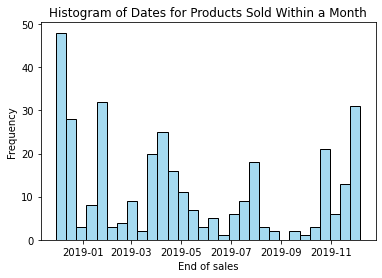

In [98]:
sns.histplot(data=month_products, x='date_max', bins=30, color='skyblue', edgecolor='black')

# Customize the plot
plt.xlabel('End of sales')
plt.ylabel('Frequency')
plt.title('Histogram of Dates for Products Sold Within a Month')

# Show the histogram
plt.show()

There are two peaks on the histogram reflecting 2 types of products. The right peak around 2019-11 shows new products which may be popular for a long time onwards. But the left peak in the end of 2018 shows products which are no longer sold (outdated models, out-of-fashion goods...). We saw earlier that November is the most active and the most profitable month,so no wonder, that month_products also concentrate in November (Black Friday, Cristmass Holidays).

## One day VS Everyday products. Top 10, Top 50.

We considered products that were on sale for a long time (>360 days in out data), but some of them may  be sold with great intervals between purchases(e.g. in Nov 2018 and then only in a year, in Nov 2019 - seasonal goods), while others are sold almost every day. Let's find them.

In [99]:
pr['dates_unique'].describe()

count    4060.000000
mean       68.867980
std        68.724076
min         1.000000
25%        13.000000
50%        47.000000
75%       105.000000
max       305.000000
Name: dates_unique, dtype: float64

Number of unique days of purchase varies from 1 to 305 with the mean 69 days, the median is smaller - 47 days. Let's plot a histogtam.

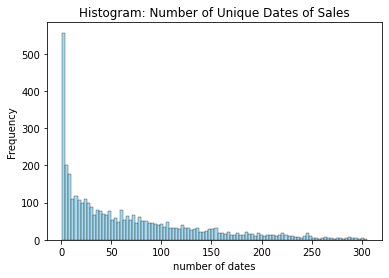

In [100]:
sns.histplot(data=pr, x='dates_unique', bins=100, color='skyblue', edgecolor='black')

# Customize the plot
plt.xlabel('number of dates')
plt.ylabel('Frequency')
plt.title('Histogram: Number of Unique Dates of Sales')

# Show the histogram
plt.show()

We know from the previous analysis thet the shop was open 305 days of 373 days of observation period( - Sundays and holidays), so products sold in >300 days are really everyday products.

Let's find **Top 10 everyday products**.

In [101]:
top_everyday= pr. sort_values(by = 'dates_unique', ascending =False ).reset_index()
top_everyday.head(10)


index stockcode  price_var  price_min  price_max  price_avg  quantity  \
0   3536    85123A          8       0.00       5.91   3.104037     38811   
1   3515    85099B         13       0.00       4.95   2.470965     47260   
2   1348     22423         10       0.00      32.04  13.787482     12954   
3   3305     84879          6       0.00       3.19   1.721155     36122   
4    454     21212          8       0.40       5.00   0.758698     36016   
5    180     20725          8       1.45       8.33   2.116919     18858   
6   1381     22457          5       2.55       6.95   3.581164      9067   
7   2733     47566         16       0.00      15.79   5.782134     18010   
8   1862     22960          9       0.00       9.95   5.011294      8459   
9   1147     22197          6       0.72       2.46   1.035634     56427   

     revenue   date_min   date_max  dates_unique  description_var  \
0   97838.45 2018-11-29 2019-12-07           305                4   
1   92175.79 2018-11-29 2019-12-07           302                1   
2  164459.49 2018-11-29 2019-12-07           301                3   
3   58792.42 2018-11-29 2019-12-07           300                2   
4   21047.07 2018-11-29 2019-12-07           299                1   
5   35007.66 2018-11-29 2019-12-07           299                2   
6   27839.01 2018-11-29 2019-12-07           298                1   
7   98243.88 2018-12-01 2019-12-07           296                1   
8   36069.34 2018-11-29 2019-12-07           295                1   
9   50967.92 2018-11-29 2019-12-07           294                2   

                          description  time_delta  
0  WHITE HANGING HEART T-LIGHT HOLDER         373  
1             JUMBO BAG RED RETROSPOT         373  
2            REGENCY CAKESTAND 3 TIER         373  
3       ASSORTED COLOUR BIRD ORNAMENT         373  
4     PACK OF 72 RETROSPOT CAKE CASES         373  
5             LUNCH BAG RED RETROSPOT         373  
6     NATURAL SLATE HEART CHALKBOARD          373  
7                       PARTY BUNTING         371  
8            JAM MAKING SET WITH JARS         373  
9                SMALL POPCORN HOLDER         373

The leader is WHITE HANGING HEART T-LIGHT HOLDER - really everyday product, sold 305 days! The last in top 10 is SMALL POPCORN HOLDEr sold 294 days. Everyday products can't be very expensive, their revenue is not so big - but regular!
Let's find top 50 everyday products and calculate its share in total revenue.

In [ ]:
everyday = top_everyday.head(50) 
everyday

In [ ]:
50/pr.stockcode.nunique()

Our 50 everyday products are sold on 270 - 305 days , they costitute only 1.23% of all products, but they give about 15.7%  of total revenue! 

In [ ]:
everyday.revenue.sum()/pr.revenue.sum()

So, everyday products is most important category - high demand goods, most often sold through the whole year, bringing more than 15% of total revenue.

# Step 5. Test hypothesis: the share of everyday products among all products in summer and winter is different. Compare summer and autumn sales per everyday product's revenue and quantity.

## Problem statement. Monthly distribution of everyday products.

We already know, that in autumn months sales grow both in quantity and in revenue. We defined everyday products as our top 50 most often sold products, which were sold on 270 days or more. In summer and in autumn the assortment of goods is very different, but everyday products are still on sale. In autumn total sales grow by quantity and revenue, but what about everyday products? Do its sales also grow in autumn?  Does everyday products share grows in autumn too? The ansers are not so evident.


Before comparing summer and autumn sales let's consider monthly changes. We've already described  overall monthly changes, let's now distinguish between everyday products VS total products.

We need our initiad `data` where dates of each transaction are stored, but let's leave only row for products and drop non-product stockcodes, as we did for `pr` dataframe.

In [ ]:
values_to_drop = ['DOT', 'M', 'POST', 'D', 'S', 'B','AMAZONFEE', 'BANK CHARGES', 'CRUC', 'CRUK', 'm']
data_cl= data[~data['stockcode'].isin(values_to_drop)]
data_cl.head(2)

Let's choose from `data_cl` only rows for everyday productsand store in `data_everyday`.

In [ ]:
everyday_stockcodes = everyday['stockcode'].tolist()
data_everyday = data_cl[data_cl['stockcode'].isin(everyday_stockcodes)]
data_everyday

Let's group data in `data_cl` and `data_everyday` by month and find quantity and revenue for each month.

In [ ]:
monthly_total= data_cl.groupby('month'). agg({'quantity':'sum', 'revenue':'sum'}).reset_index()
monthly_total.head()

In [ ]:
monthly_everyday= data_everyday.groupby('month'). agg({'quantity':'sum', 'revenue':'sum'}).reset_index()
monthly_everyday.head()

Let's plot graphs for monthly distribution of total products and everyday products metrics: quantity and revenue.

In [ ]:
plt.figure(figsize=(12, 6))
bar_width = 0.35
plt.bar(monthly_everyday.index - bar_width/2, monthly_everyday['quantity'], bar_width, label='Quantity (Everyday)', color='skyblue')

plt.bar(monthly_total.index + bar_width/2, monthly_total['quantity'], bar_width, label='Quantity (Total)', color='lightblue')
plt.xlabel('Month')
plt.ylabel('Monthly Quantity')
plt.title('Comparison of Quantity by Month (Everyday vs. Total)')
plt.xticks(monthly_everyday.index, monthly_everyday['month'], rotation=45)
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
bar_width = 0.35
plt.bar(monthly_everyday.index - bar_width/2, monthly_everyday['revenue'], bar_width, label='Revenue (Everyday)', color='orange')

plt.bar(monthly_total.index + bar_width/2, monthly_total['revenue'], bar_width, label='Revenue (Total)', color='lightcoral')
plt.xlabel('Month')
plt.ylabel('Monthly Revenue')
plt.title('Comparison of Revenue by Month (Everyday vs. Total)')
plt.xticks(monthly_everyday.index, monthly_everyday['month'], rotation=45)
plt.legend()
plt.show()

We clearly see that total sales grow in autumn both by quantity and by revenue, but everyday products do not grow linearly, in August they were sold in greater quantity and with higher revenue, than in September and October. We  see by graph that everyday products' share  is decreasing in autumn, so we may **suppose that everyday products behavior is special, their share in total quantity and total revenue in summer and in autumn is different**.

## Prepare test data
Let's use the tesr of proportions to check whether everyday products' shares in summer and in autumn differ by quantity and by revenue. 

The proportion test compares the shares of successes in two samples and evaluates if the samples can belong to one and the same population or not. In our case successes are quantity and revenue values for everyday products, samples are the same values for all products. We'll compare summer and autumn results.

Let's prepare values for the test.

The tables `monthly_total` and  `monthly_everyday` can be used to compare  monthly figures, but we need only summer and winter  2019 figures for our test. Let's  take months we need in lists.

In [ ]:
summer = ['2019-05-01', '2019-07-01', '2019-08-01']
autumn = ['2019-09-01', '2019-10-01', '2019-11-01']

Now let's find summed quantity and revenue values for summer and autumn total and everyday products.

In [ ]:
summer_total = monthly_total[monthly_total['month'].isin(summer)].sum()
autumn_total = monthly_total[monthly_total['month'].isin(autumn)].sum()

summer_everyday= monthly_everyday[monthly_everyday['month'].isin(summer)].sum()
autumn_everyday = monthly_everyday[monthly_everyday['month'].isin(autumn)].sum()

In [ ]:
summer_total

In [ ]:
autumn_total

In [ ]:
summer_everyday

In [ ]:
autumn_everyday

Now we have all necessary data and can test our hypothesis. We have to check if 419619.81/2218831.671 (summer revenue proportion) is statistically different  from  428923.29/3531888.951 (autumn revenue proportion), the same for quantity.

## Test hypotheses and interpret the results.

We compare summer and autumn samples. 

Let's formulate our  hypoteses:
- HO: The shares of everyday products in total sales(quantity, revenue) are the same in summer and autumn.
- H1: The shares of everyday products in total sales(quantity, revenue) are different in summer and autumn.

We set significance level alpha to 0.05 and cunduct the test of proportions.

First we **test quantity** for total products(trials) and everyday products(successes).

In [ ]:
alpha = 0.05

trials = np.array([ 2218831.671, 3531888.951])
successes = np.array([419619.81, 428923.29])

# success proportion in summer:
p1 = successes[0]/trials[0]

# success proportion in autumn:
p2 = successes[1]/trials[1]

# success proportion in the combined dataset:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# the difference between the datasets' proportions
difference = p1 - p2
# calculating the statistic in standard deviations of the standard normal distribution
#z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# setting up the standard normal distribution (mean 0, standard deviation 1)
distr = st.norm(0, 1)
# calculating the statistic in standard deviations of the standard normal distribution
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# setting up the standard normal distribution (mean 0, standard deviation 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if (p_value < alpha):
    print("Rejecting the null hypothesis: there is a significant difference between the proportions")
else:
    print("Failed to reject the null hypothesis: there is no reason to consider the proportions different")


Summer and autumn samples are really different.

Now let's repeat the **test for revenue**:

In [ ]:
trials = np.array([1226765.000, 1863959.000])
successes = np.array([208269.00, 212373.00])

# success proportion in summer:
p1 = successes[0]/trials[0]

# success proportion in autumn:
p2 = successes[1]/trials[1]

# success proportion in the combined dataset:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# the difference between the datasets' proportions
difference = p1 - p2
# calculating the statistic in standard deviations of the standard normal distribution
#z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# setting up the standard normal distribution (mean 0, standard deviation 1)
distr = st.norm(0, 1)
# calculating the statistic in standard deviations of the standard normal distribution
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# setting up the standard normal distribution (mean 0, standard deviation 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if (p_value < alpha):
    print("Rejecting the null hypothesis: there is a significant difference between the proportions")
else:
    print("Failed to reject the null hypothesis: there is no reason to consider the proportions different")

For both quantity and revenue we got the same result: p-value is much lower than alpha, so we should reject the null hypothesis about equality. So, the difference between the proportions is statistically significant by quantity as well as by revenue.

This test results confurm that everyday products constitute a speciall group, it behaves differently from other products. Its monthly quantity  and revenue do not grow so much in autumn, its share among all products in summer and in autumn is different (becomes smaller in autumn), and this difference is statistically significant. So, seasonal factors have a big impact  on everyday products too.

# Step 6. RFM analysis.
Let's use Recency-Frequency-Monetary value method  to find  clusters among products.

In `pr` df we already have Frequancy (=quantity) and Monetary value(= revenue) for each product. Recency parameter can be calculated How recent was the customer's last purchase

In [ ]:
pr['date_max'].max()

In [ ]:
NOW=dt.datetime(2019,12,7)
NOW

In [ ]:
pr['recency'] = (NOW - product['date_max']).dt.days
pr['recency']

In [ ]:
rfm=pr[['stockcode','description', 'recency', 'quantity', 'revenue']]
rfm.columns = ['stockcode','description', 'recency','frequency','monetary_value']
rfm                   

Let's study  our metrics with describe().

In [ ]:
rfm.recency.describe()

Recency varies from 0 to 373, the mean value is 151.1, while the median is only 120, so the distribution should be right-skewed.

In [ ]:
for i in rfm.columns:
    if i in ['stockcode', 'description'] :
        continue
    else: 
        plot_data=[
            go.Histogram(x=rfm[i])
        ]
        plot_layout=go.Layout(title=i)
        fig=go.Figure(data=plot_data,layout=plot_layout)
        pyoff.iplot(fig)

We want to split the data by each metrics into portions and label them. Let's use qcut() function, it performs quantile-based splitting of a continuous variable into discrete intervals so that each of them represents a similar portion of the data.

Let's devide data into 4 bins, so we'll need 4 labels for them.

In [ ]:
f_labels = range(1,5)

In [ ]:
f_labels = range(1,5)
rfm['F']=pd.qcut(rfm.frequency,q=4,labels=f_labels)
rfm['F']

Labels in `F` are of category type and they represent portions of `fequency` values in ascending order.

In [ ]:
rfm[['frequency', 'F']]

In [ ]:
rfm.groupby(['F'])['frequency'].describe()

In [ ]:
pr[ pr['quantity'] == -14468.0]

The number of values in bins is more or less the same. The  frequency values are devided into 4 ranges:
 [-14468; 41], [42; 333], [334; 1321], [1323; 56427].

Let's do the same for monetary_value.


In [ ]:
m_labels=range(1,5)
rfm['M']=pd.qcut(rfm.monetary_value,q=4,labels=m_labels)
rfm['M']

In [ ]:
m_labels_=range(1,4)
rfm['M_']=pd.qcut(rfm.monetary_value,q=3,labels=m_labels_)
rfm['M_']

In [ ]:
rfm[['monetary_value', 'M']]

In [ ]:
rfm.groupby(['M'])['monetary_value'].describe()

`M` labels mark 'monetary_value' values as belonging to 4 ranges: [-54; 95.94], [96.5; 613.17], [615.37; 2080,85], [2082.9; 164459.49].

Let's consider `recency`. Unlike for frequency and monetary value, the smaller recency - the better (the product is still popular), so the labels should come in descending order.

In [ ]:
r_labels=range(4,0,-1)
rfm['R']=pd.qcut(rfm.recency,q=4,labels=r_labels)
rfm['R']

In [ ]:
rfm.groupby(['R'])['recency'].describe()

`recency` values are devided into 4 ranges: [0; 9], [10; 120], [121; 320], [322; 373].

The number of values in bins is more or less the same. 

**So**, we devided each rfm metrics into 4 ranges and assigned labels to them so that the better result gets the greater label.

## Assign each product RFM score. 

Now we can combine the labels and assign each product to `RFM_segment`.

In [ ]:
rfm['RFM_segment']=rfm['R'].astype(str)+rfm['F'].astype(str)+rfm['M'].astype(str)
rfm

In [ ]:
rfm['RFM_segment'].nunique()

Yes, we got all 61 segments out of 64 possible combinations. Let's look at RFM segments.

In [ ]:
rfm['RFM_segment'].value_counts()

## Split products into clusters. What is special about each cluster? Describe them. Try to give some recommendations for business based on clusters.


RFM segments  fall between the two extremes for the future product clustering:
- 444 - the best products sold recently, frequently(in large quantities) and with high revenue.
- 111 - just  the opposite, the worst products: sold long ago(are not in demand now), seldom(in small quantities) with low revenue.
61 groups is very much, it's difficult to compare them, but still we can find some meaningful categories which would be hidden if we simply sum label values and get the total score. Summed 411 and 114 give the same number, but 411 is for products that have just appeared and no one knows how they will be sold tomorrow, and 114 is for expencive products bought once long ago. So we group rfm segments into 8 clusters : **Star**,  **Best**, **Reliable**, **Promising**,  **Actual**, **Still Alive**, **Losing Revenue**, **Losing Cheap**,**Trash** .

To assign the cluster's name to each product let's create a function:

In [ ]:
def rfm_name(x):
    if x=='444':
        return "Star"
    
    elif x in ('443', '442', '434', '424', '433',  '344', '343', '334', '333','324', '314','244' ):
        return "Best"
    
    elif x in ('431', '432', '342', '332', '322',  '313', '323','321',  '331', '311', '312'):
        return "Reliable"
    
    elif x in ( '234', '243','242','214', '224', '241', '233', '223','213'):
        return "Promising "
    
    elif x in ( '423', '422', '421', '414', '413', '412', '411'):
        return "Actual"
    
    elif x in ('222',  '231', '232',  '221','211', '212'):
        return "Still Alive"
    
    elif x in ('144', '143', '134', '133', '124', '123','114', '113' ):
        return "Loosing Revenue"
    
    elif x in ('112', '122', '121', '132', '131',  '141','142'): 
        return "Looosing Cheap"
    
    elif x in ('111'):
        return "Trash"
    else:
        return "Others"

In [ ]:
rfm['group']=rfm['RFM_segment'].apply(rfm_name)
rfm.head()

In [ ]:
rfm[rfm['group'] == "Others"].RFM_segment.value_counts()

In [ ]:
groups = rfm.groupby('group'). agg(count = ('monetary_value', 'count'),
                                                     avg_recency = ('recency','mean'),
                                                     avg_frequency = ('frequency', 'mean'),
                                                     avg_monetary = ('monetary_value', 'mean'),
                                  total_revenue = ('monetary_value', 'sum')). sort_values (by = 'avg_monetary', ascending =False).reset_index()      
groups

The first and the last goups are similar in size, they are the smallest of all groups. The largest group is Best.

We can make plots and compare parameters by group.

In [ ]:
parameters = ['avg_recency', 'avg_frequency', 'avg_monetary', 'total_revenue']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the 2D axes array for easy indexing
axes = axes.flatten()

for i, param in enumerate(parameters):
    sns.barplot(data=groups, x='group', y=param, palette='viridis', ax=axes[i])
    axes[i].set_xlabel('Group')
    axes[i].set_ylabel(param)
    axes[i].set_title(f'Average {param} by Group')
    axes[i].tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()



We sorted groups by monetary value and it goes down  with the group's index on the plot, while frequency doesn't always does it, and  Avg_recency is jumping from group to group up and down. 'Trash' has negative  average frequency(because of returnes). 'Best' group gives max total revenue(expected). Loosing revenue is on the 3rd pace by average revenue and quantity, but it's the second by totall revenue - these expensive pruducts brought high revenue months ago, it would be a pity to lose them. Look at these groups shares in total revenue:



In [ ]:
rfm[rfm['group']. isin(['Star', 'Best'])] ['monetary_value'].sum()/rfm['monetary_value'].sum()

In [ ]:
rfm[rfm['group']. isin(['Loosing Revenue'])] ['monetary_value'].sum()/rfm['monetary_value'].sum()



Let's describe all groups and try to give some recommendations. 

1. rfm 444: **Star** - the highest revenue, the largest quantity, the most recent sales.
2. rfm 443, 442, 434, 424, 433, 344, 343, 334, 333, 324, 314, 244 : **Best** - high revenue, sold not long ago.
3. rfm 144, 143, 134, 133, 124, 123, 114, 113 **Loosing Revenue** - sold long ago with high revenue, no more sales.
4. rfm 234, 243, 242, 224, 241, 233, 223, 213:  **Promising** - last sold 4 months with noticeable quantity or revenue
5. rfm 423, 422, 421, 414, 413, 412, 411:  **Actual** - most recently sold in moderate quantity with any revenue
6. rfm 112, 122, 121, 132, 131, 141, 142:  **Loosing Cheap** - sold long ago with little revenue 
7. rfm 431, 432, 342, 332, 322, 313, 323, 321, 331, 311, 312: **Reliable**  - sold in noticeable quntities not so long ago 
8. rfm 222, 231, 232, 221, 211, 212: **Still Alive** - last sold 4 months ago in small quantity at low price
9. rfm 444: **Trash** - sold long ago or returned with minimal/no revenue 

- Star Products and Best Products are the leaders, they bring 65.3% of total monetary value, so their sales should be promoted to increase the store's revenue. Close to them are Reliable products with smaller revenue but with teady demand, they need marketing support. 
- Promising  and Steel Alive were sold  months ago, but Pomising were more successful and they may return later (in case of seasonal dependency), while Steel Alive have less chance of success and may leave the stage.
- Actual products may have just went on sale, we need time to understant to what extent they will be popular.
- Loosing Revenue and Loosing Cheap products were sold almost a year ago (to be precise, more than 332 days ago), but while Loosing Cheap  products can be dropped almost without any noticeable lost, Loosing Revenue products need special attention. These products brought significant revenue in the past(22%), but then nobody buys them - why? Are they out of fashion and there's no sense to keep them selling, or are they sold once a year(Happy New Year!) and will be sold just in a week or two?
- Trash products should not be sold at all. 

**Conclusion**

So, with RFM analysis `Recency`, `Frequency` and `Monetary_value` values were devided into 4 ranges:

- Recency: [0; 9], [10; 120], [121; 320], [322; 373]  days days from the end of the observation period;
- Frequency:  [-14468; 41], [42; 333], [334; 1321], [1323; 56427] units sold;
- Monetary_value: [-54; 95.94], [96.5; 613.17], [615.37; 2080,85], [2082.9; 164459.49] $ total revenue.

Each product was assigned to 1 of 4 ranges at each parameter and got RFM score, there were 61 different scores. Then the scores were grouped into clusters - groups of products with common characteristics. We got 9 groups of products, describedthem. The distributions of `Recency`, `Frequency` and `Monetary_value` and Total_revenue per group were plotted, reccommendations for each group were given.


# Step 8. General conclusion and recommendations


We analyzed the transaction history of an online store from 2018-11-29 to 2019-12-07. 
1. **Initial dataset of 541909 rows** * 7 columns was preprocessed, the core parameters  were analized in general, **per transaction**: 
- quantity: - the mean 9.55, max 80995;
- price: the mean 4.61, max 38970;
- revenue was calculated as price * quantity: the mean 17.9, maximum 168469
- time dynamics of quantity and revenue was investigated: daily, weekly, monthly changes and distribution per days of the week were analysed. 

2. **Per product analysis** of  new grouped parameters for **4060 products** included several directions:
- Fixed VS Flexible Prices: 466 products are sold at just 1 price, while 208 products have 8 or more price variants. For fixed-price products the mean quantity is much smaller than that of the whole sample (21.6 VS 1308.5), so the revenue is smaller too(54.3 VS 2484.5). Flexible price products do not differ from other products by price, but the mean quantity and revenue are much greater (5337.2 VS 1308.5, 13517.2 VS 2484.5). High **positive correlation** is found not only between  `revenue` and `quantity`(0.69) as expected, but also between  `revenue` and `price_var`(0.47),  `quantity` and `price_var`(0.4). Price discounts increase the customers' interest, that's why the quantity of items sold and the revenue grow for flexible products. **The more flexible prices are, the higher the revenue**!  
- **High VS Low Prices**: Top 10 and Bottom 10 products by price are found. The leader by price is PICNIC BASKET WICKER SMALL whith price 649.5$.
- **Large VS small quantity**: Top 10 by popularity found, the leader is POPCORN HOLDER with quantity 56450 items sold. 57 products sold once, 10 of them with the earliest date of sale are Bottom 10 by popularity.
- **Returned products**: From Top 10 by returnes TRAVEL CARD WALLET I LOVE LONDON is the worst- 14418 units returned.
- **High VS Low Revenue products**: Top ten and Bottom 10 by revenue found, the leader is REGENCY CAKESTAND 3 TIER which brought 164.7622k. The worst product  is WHITE CHERRY LIGHTS, its revenue is -54.0 . There are also 24 products with zero revenue - damaged products or given free.
- **Long-time VS One-day/One-month on sale** products: the interval between max and min dates of purchase was analysed, the mean is 276 days, max 373 days (the whole observation period). 1206 products are sold within >= 370 days, 239 products sold within 1 day, 370 products sold within a month. These products may be new on sales or be sold long time ago, it's a hard to interpret characteristics. 
- **Everyday products**: sold on max number of different dates. The leader is WHITE HANGING HEART T-LIGHT HOLDER  sold 305 days(all days the store was open)  The last in top 10 is SMALL POPCORN HOLDER sold 294 days. Top 50 everyday products were found sold on 270 - 305 days, they costitute only 1.23% of all products, but give about 15.7% of total revenue.

3. **Test hypothesis** part: Everyday products and total products metrics were compared by monthly distribution. In autumn months sales grow both in quantity and in revenue, but  for everyday products monthly don't always grow, and their share decreases. We suppose that everyday products behavior is special, their share in total quantity and total revenue in summer and in autumn is different. The test of proportions was used with alpha 0.05 to check the hypotheses: 
- HO: The shares of everyday products in total sales(quantity, revenue) are the same in summer and autumn.
- H1: The shares of everyday products in total sales(quantity, revenue) are different in summer and autumn.
Summer and autumn samples were compared, quantity and revenue values for total products were regarded as trials, the same metrics for everydaysproducts as successes.
For both quantity and revenue we got the same result: p-value is much lower than alpha, so we should reject the null hypothesis about equality. So, the difference between the proportions is statistically significant by quantity as well as by revenue.

This test results confirm that everyday products constitute a speciall group, it behaves differently from other products. Its monthly quantity and revenue do not grow so much in autumn, its share among all products in summer and in autumn is different(becomes smaller in autumn), and this difference is statistically significant.

4. **RFM analysis** was used for clustering: values for Recency, Frequency and Monetary Value were split into 4 ranges and labeled, each product got rfm score. Then 61 unique rfm scores were divided into 9 groups: Star, Best, Reliable,  Promising, Actual, Still Alive, Losing Revenue, Losing Cheap, Trash. Star Products and Best Products are the leaders, they bring 64.2% of total revenue, so their sales should be promoted to increase the store's revenue. Close to them are Reliable products with smaller revenue but with steady demand, they need marketing support.
Promising and Steel Alive were sold months ago, but Pomising were more successful and they may return later (in case of seasonal dependency), while Steel Alive have less chance of success and may leave the stage.
Actual products may have just went on sale, we need time to understand to what extent they will be popular.
Loosing Revenue and Loosing Cheap products were sold almost a year ago (to be precise, more than 332 days ago), but while Loosing Cheap products can be dropped almost without any noticeable lost, Loosing Revenue products need special attention(24.5 % of total revenue, but for many months no new sales). Trash products should not be sold at all.

**Recommendations** to increase revenue:
- more flexible pricing policy will increase the customers interest;
- use ratings we came to in increasing product assortment, to  promote most popular, most profitable, most regular sold products that generate the greatest income;
- to address the returned products, as they significuntly reduce revenue. In many cases returnes are connected with damage, so we need to ensure proper storage and reliable delivery of all products, take care of the safety of goods to decrease losses;
- to treat products in accordanse with rfm score, follow recommendations given for rfm groups;
- to get rid of products in bottom 10 by revenue, bottom 10 by popularity products(they are also Trash and Losing Cheap groups by rfm score), they don't make a lote of money; 
- to pay special attention to Losing Revenue products, to study the posibilities of their sales reviving;
- to give maximum support to everyday products(top 50), as they are always in demand and bring very good revenue, but the store has to prepare to autumn change in their sales;
- to request for deeper analysis of seasonal changes in sales over the year for all product categories and to take  into account its results.

# Step 9. Preparing a presentation and Tableau dashboard.